In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "24"

import pandas as pd
import numpy as np
from joblib import Parallel, delayed
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import scanpy as sc
import matplotlib
from tqdm import tqdm

matplotlib.rcParams['pdf.fonttype'] = 42
from hdbscan import HDBSCAN

from perturbseq import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

# Parameters

In [2]:
PREFIX = '20240125_RPE1_E150_essentials_'
EXPERIMENT = '/data/norman/southark/rpe1e150_standardized/'

In [3]:
full_pop = CellPopulation.from_hdf('/data/norman/southark/rpe1e150_standardized/20240227_RPE1_E150_all_genes.hdf')

Loading matrix...
Loading metadata...
Done in 82.20826172828674s.
Done.


In [4]:
full_pop.cells['number_of_cells'].sum()

140182

In [9]:
full_pop.cells.query('gem_group==2')

,dataset,UMI_count,number_of_cells,num_features,feature_call,num_umis,guide_identity,guide_umi_count,good_coverage,gem_group,...,perturbed,single_cell,mt_frac,keep,control,pairwise_coef,pairwise_UMI_count,pairwise_singlet_equivalent_UMI_count,old_final_pairwise_UMI_count,final_pairwise_UMI_count
AAACCCAAGAAATTCG-2,max_ol,12576.0,2,2.0,2553_EIF3I_P1P2_ENSG00000084623|7525_RPS3_P1_E...,374|76,2553_EIF3I_P1P2_ENSG00000084623,374.0,True,2,...,EIF3I,True,0.004930,True,False,1.835041,23077.480394,1.129723,10844.323186,11493.046275
AAACCCAAGAAGATCT-2,max_ol,6298.0,1,1.0,5699_NKX6-1_P1P2_ENSG00000163623,57,5699_NKX6-1_P1P2_ENSG00000163623,57.0,True,2,...,NKX6-1,True,0.013496,True,False,1.557330,9808.063607,0.834264,8061.911882,8172.391330
AAACCCAAGACAGCGT-2,max_ol,4361.0,1,1.0,2794_EXOSC7_P1P2_ENSG00000075914,104,2794_EXOSC7_P1P2_ENSG00000075914,104.0,True,2,...,EXOSC7,True,0.016969,True,False,2.392222,10432.479070,0.887377,8282.293892,8590.600770
AAACCCAAGCAGCACA-2,max_ol,12155.0,2,2.0,5901_NUP85_P1P2_ENSG00000125450|8670_TAF8_P1P2...,1005|2248,8670_TAF8_P1P2_ENSG00000137413,2248.0,True,2,...,TAF8,True,0.006582,True,False,1.637691,19906.137383,0.974475,9552.761736,9912.114363
AAACCCAAGCATTGTC-2,max_ol,43184.0,3,3.0,127_ADAM10_P1P2_ENSG00000137845|9683_UTP18_P1P...,3020|2002|1277,127_ADAM10_P1P2_ENSG00000137845,3020.0,True,2,...,ADAM10,True,0.006901,True,False,0.719721,31080.414660,1.128361,10520.251062,11110.191605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGTCTACGGGC-2,max_ol,20327.0,1,1.0,9482_UBA52_P1_ENSG00000221983,439,9482_UBA52_P1_ENSG00000221983,439.0,True,2,...,UBA52,True,0.003001,True,False,0.523584,10642.899628,0.905275,8986.398734,9113.329088
TTTGTTGTCTAGAACC-2,max_ol,7513.0,1,1.0,2527_EIF1AX_P1P2_ENSG00000173674,224,2527_EIF1AX_P1P2_ENSG00000173674,224.0,True,2,...,EIF1AX,True,0.004792,True,False,1.437204,10797.717007,0.918443,9173.303741,9258.325018
TTTGTTGTCTCAGAAC-2,max_ol,13363.0,2,2.0,9683_UTP18_P1P2_ENSG00000011260|non-targeting_...,640|34,9683_UTP18_P1P2_ENSG00000011260,640.0,True,2,...,UTP18,True,0.002769,True,False,1.825455,24393.555695,1.194149,11418.299987,12157.346501
TTTGTTGTCTGTAAGC-2,max_ol,24443.0,5,5.0,4464_KPNB1_P1P2_ENSG00000108424|4956_MED6_P1P2...,254|368|275|609|234,7480_RPL8_P1P2_ENSG00000161016,609.0,True,2,...,RPL8,True,0.010555,True,False,1.406428,34377.310212,0.948540,9206.944303,9768.038935


## Make a figure of droplet composition

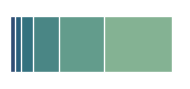

In [5]:
# Calculate the relative composition of each category
composition = full_pop.cells['number_of_cells'].value_counts(normalize=True) * 100

# Create a DataFrame for Seaborn
data = pd.DataFrame({'Number of Cells': composition.index, 'Percentage': composition.values})
data['point'] = 1

# Sort the data in descending order based on the 'Percentage' column
data = data.sort_values('Percentage', ascending=False)

# Create a sideways stacked bar chart using Seaborn
sns.set_style('white')
fig, ax = plt.subplots(figsize=(2, 1))  # Set figure size to 2x2 inches
bar = sns.barplot(x='Percentage', y='point', hue='Number of Cells', data=data, dodge=False, palette='crest', orient='h', ax=ax)

# Remove axes, grid, and frame
ax.axis('off')
ax.set_frame_on(False)
ax.grid(False)

# Remove the legend
ax.legend_.remove()

# Display the chart
plt.tight_layout()
plt.savefig('20240408_E150_composition.pdf', bbox_inches='tight')

In [6]:
full_pop.cells['number_of_cells'].value_counts()

1    33681
2    19512
3    10272
4     4854
5     2237
6     1010
Name: number_of_cells, dtype: int64

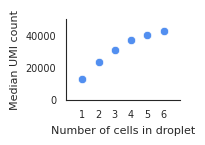

In [13]:
df = full_pop.cells.query('gem_group==1 and number_of_cells <= 6')[['UMI_count', 'number_of_cells']].groupby('number_of_cells').median()

# Set the figure size and create a new figure
fig, ax = plt.subplots(figsize=(2, 1.5))

# Create the scatter plot
sns.scatterplot(data=df, x=df.index, y='UMI_count', ax=ax, color='#528FF0')

# Set the labels and title
ax.set_xlabel('Number of cells in droplet', fontsize=8)
ax.set_ylabel('Median UMI count', fontsize=8)

# Adjust the tick label font size
ax.tick_params(axis='both', labelsize=7)

# Remove the top and right spines
sns.despine()

plt.ylim([0, 50000])
ax.set_xticks(np.arange(1, 7))
ax.set_xticklabels(np.arange(1, 7))
plt.xlim([0, 7])

# Adjust the layout to minimize whitespace
plt.tight_layout()

# Display the plot
plt.savefig('20240407_median_UMI_count_per_droplet.pdf', bbox_inches='tight')

In [14]:
df.div(df.loc[1])

,UMI_count
number_of_cells,
1,1.000000
2,1.788989
3,2.369692
4,2.821777
5,3.070798
6,3.280734


# Explore various possible data normalizations, including stably captured genes

In [7]:
from itertools import combinations
from scipy.stats import wasserstein_distance
from itertools import combinations

In [8]:
def get_p(pop, genes=None, UMI_counts=None):
    if UMI_counts is None:
        UMI_counts = pop.cells['UMI_count']
    
    ps = dict()
    
    for gem in tqdm(pop.cells['gem_group'].unique()):
        gem_group_cells = pop.cells[pop.cells['gem_group']==gem].index
        
        p = pop.where(cells=gem_group_cells, genes=genes).copy()
        # normalize to probabilities
        p = p.div(UMI_counts.loc[gem_group_cells], axis=0)
                    
        ps[gem] = p
    
    ps = pd.concat(ps.values())

    return ps

def get_stratified_expression(pop, stratify, cells=None, genes=None, normalized=False, normalized_name=None, **kwargs):
    expr = pop.where(cells=cells, genes=genes, normalized=normalized, normalized_name=normalized_name, **kwargs).copy()
    
    for key in stratify:
        expr[key] = pop.cells[key]
        
    expr.set_index(stratify, append=True, inplace=True)
    levels_order = expr.index.names
    new_order = levels_order[1:] + [levels_order[0]]
    expr = expr.reorder_levels(new_order)

    return expr

def pairwise_sum_wasserstein(p):
    number_of_cells = p.index.get_level_values(0).unique()
    
    dists = list()
    for (n1, n2) in combinations(number_of_cells, 2):
        dists.append(wasserstein_distance(p.loc[n1], p.loc[n2]))
    return np.sum(dists)

In [9]:
from scipy.stats import trim_mean

def p_normalize(pop, genes=None, UMI_counts=None, UMI_constant=10000, normalize_to_constant=True, scale_by_number_of_cells=False, normalize_to_singlets=False, trim=False, proportion_to_cut=0.02, return_Q=False, fillna=False):
    if UMI_counts is None:
        UMI_counts = pop.cells['UMI_count']
    
    normalized = dict()
    if return_Q:
        Qs = dict()
    
    for gem in tqdm(pop.cells['gem_group'].unique()):
        gem_group_cells = pop.cells[pop.cells['gem_group']==gem].index
        
        p = pop.where(cells=gem_group_cells, genes=genes).copy()
        # normalize to probabilities
        p = p.div(UMI_counts.loc[gem_group_cells], axis=0)
        
        p['number_of_cells'] = pop.cells['number_of_cells']
        p.set_index('number_of_cells', append=True, inplace=True)
        
        # observed average probability per transcript by number_of_cells
        if trim: # trimmed mean to reduce dependence on outliers
            P = dict()
            for level, df in p.groupby(level=1):
                P[level] = df.apply(lambda x: trim_mean(x, proportion_to_cut))
            P = pd.DataFrame(P).T
        else:
            P = p.groupby(level=1).mean()
        
        if normalize_to_singlets:
            mu = P.loc[1]
        else:
            if trim:
                mu = p.apply(lambda x: trim_mean(x, proportion_to_cut))
            else:
                mu = p.mean()
        
        # normalize to equal average probability across all droplets to yield scale factors
        Q = P.div(mu)
        
        if return_Q:
            Qs[gem] = Q
        
        factors = pd.DataFrame(Q.loc[p.index.get_level_values(1)].values, index=p.index, columns=p.columns)
        
        if normalize_to_constant and scale_by_number_of_cells:
            # normalize singlets to 10k, doublets to 20k, triplets to 30k, etc.
            p = (p/factors).mul(p.index.get_level_values(1)*UMI_constant, axis=0).droplevel(1)
        elif normalize_to_constant and not scale_by_number_of_cells:
            # normalize all to 10k
            p = (p/factors).droplevel(1)*UMI_constant
        else:
            # normalize back by original observed number of UMIs
            p = (p/factors).droplevel(1).mul(UMI_counts.loc[gem_group_cells], axis=0)
            
        if fillna:
            normalized[gem] = p.fillna(0)
        else:
            normalized[gem] = p
    
    if return_Q:
        return pd.concat(normalized.values()), Qs
    else:
        return pd.concat(normalized.values())

In [10]:
def offset_p_normalize(pop, scale_factors, control_cell_query, genes=None, UMI_counts=None, UMI_constant=10000, normalize_to_constant=True, scale_by_number_of_cells=False, normalize_to_singlets=False, trim=False, proportion_to_cut=0.02, standardize=False, normalize_to_controls=True):
    # normalize transcript capture probability
    p = p_normalize(pop,
                    genes=genes,
                    UMI_counts=UMI_counts,
                    UMI_constant=UMI_constant,
                    normalize_to_constant=normalize_to_constant,
                    scale_by_number_of_cells=scale_by_number_of_cells,
                    normalize_to_singlets=normalize_to_singlets,
                    trim=trim,
                    proportion_to_cut=proportion_to_cut)
    
    # adjust UMI content according to scale factors
    p = p.mul(scale_factors, axis=0)
    
    # subtract control offsets
    if normalize_to_controls:
        control_p = p.loc[pop.cells.query(control_cell_query).index].copy()
        control_p['gem_group'] = pop.cells.query(control_cell_query)['gem_group']
        control_mu = control_p.groupby('gem_group').mean()
        offsets = pd.DataFrame(control_mu.loc[pop.cells.loc[p.index, 'gem_group']].values,
                             columns=control_mu.columns,
                             index=p.index)
    else:
        mus = p.copy()
        mus['gem_group'] = pop.cells['gem_group']
        mus = mus.groupby('gem_group').std()
        offsets = pd.DataFrame(mus.loc[pop.cells.loc[p.index, 'gem_group']].values,
                             columns=mus.columns,
                             index=p.index)

    if standardize:

        if normalize_to_controls:
            control_stds = control_p.groupby('gem_group').std()
            scales = pd.DataFrame(control_stds.loc[pop.cells.loc[p.index, 'gem_group']].values,
                             columns=control_stds.columns,
                             index=p.index)
        else:
            stds = p.copy()
            stds['gem_group'] = pop.cells['gem_group']
            stds = stds.groupby('gem_group').std()
            scales = pd.DataFrame(stds.loc[pop.cells.loc[p.index, 'gem_group']].values,
                             columns=stds.columns,
                             index=p.index)

        return (p - offsets)/scales
    else:
        return p - offsets

In [12]:
full_pop.normalized_matrix = dict()
full_pop.normalized_matrix['p'] = get_p(full_pop)

100%|████████████████████████████████████████████| 2/2 [00:13<00:00,  6.71s/it]


In [57]:
full_pop.normalized_matrix['equal_UMI'] = full_pop.normalized_matrix['p']*14500

In [21]:
full_pop.normalized_matrix['q'], Qs = p_normalize(full_pop, UMI_constant=1, return_Q=True)

100%|████████████████████████████████████████████| 2/2 [01:52<00:00, 56.04s/it]


In [22]:
full_pop.normalized_matrix['gemgroup'] = normalize_to_gemgroup_control(full_pop, control_cells='control').astype(np.float32)

Normalizing all cells to 15633.5 UMI...
groupby: index in @key_barcodes and (control) (key = gem_group)
Processing gem group 1
     Determining scale factors...


/lila/data/norman/tmn/notebooks/droplet overloading/final_code/perturbseq/expression_normalization.py:140: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version.
  if isinstance(matrix, pd.SparseDataFrame):
/lila/data/norman/tmn/notebooks/droplet overloading/final_code/perturbseq/expression_normalization.py:144: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version.
  if isinstance(control_matrix, pd.SparseDataFrame):


     Normalizing matrix to median
     Normalizing control matrix to median
     Scaling matrix to control
     Done.
12.676988363265991
Processing gem group 2
     Determining scale factors...


/lila/data/norman/tmn/notebooks/droplet overloading/final_code/perturbseq/expression_normalization.py:140: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version.
  if isinstance(matrix, pd.SparseDataFrame):
/lila/data/norman/tmn/notebooks/droplet overloading/final_code/perturbseq/expression_normalization.py:144: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version.
  if isinstance(control_matrix, pd.SparseDataFrame):


     Normalizing matrix to median
     Normalizing control matrix to median
     Scaling matrix to control
     Done.
14.737905979156494
Merging submatrices...


In [59]:
full_pop.normalized_matrix['trim_offset_norm_p'] = offset_p_normalize(full_pop,
                        full_pop.cells['pairwise_singlet_equivalent_UMI_count'],
                        'control',
                        genes='mean > 0.1',
                        UMI_constant=1,
                        scale_by_number_of_cells=False,
                        normalize_to_singlets=False,
                        trim=True,
                        standardize=True)

100%|████████████████████████████████████████████| 2/2 [00:33<00:00, 16.69s/it]


# Figures demonstrating UMI saturation effect

In [13]:
total_strat_expr = get_stratified_expression(full_pop, ['number_of_cells'], cells='gem_group==1', normalized=True, normalized_name='p', gene_names=True)

strat_expr = get_stratified_expression(full_pop, ['number_of_cells'], cells='gem_group==1', genes='mean > 1', normalized=True, normalized_name='p', gene_names=True)
mean_strat_expr = strat_expr.groupby(level=0).mean()

In [14]:
df = full_pop.cells.query('gem_group==1 and number_of_cells <= 6')[['UMI_count', 'number_of_cells']].groupby('number_of_cells').median()
df['genes_detected'] = (total_strat_expr > 0).sum(axis=1).groupby(level=0).median()
df['UMI_per_gene'] = df['UMI_count']/df['genes_detected']
df = df.div(df.loc[1])

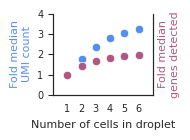

In [17]:
fig, ax1 = plt.subplots(figsize=(2, 1.5))

# Plot 1
sns.scatterplot(data=df, x=df.index, y='UMI_count', ax=ax1, color='#528FF0')
ax1.set_xlabel('Number of cells in droplet', fontsize=8)
ax1.set_ylabel('Fold median\nUMI count', fontsize=8, color='#528FF0')
ax1.tick_params(axis='both', labelsize=7)
ax1.set_ylim([0, 4])
ax1.set_xticks(np.arange(1, 7))
ax1.set_xticklabels(np.arange(1, 7))
ax1.set_xlim([0, 7])

# Plot 2
ax2 = ax1.twinx()
sns.scatterplot(data=df, x=df.index, y='genes_detected', ax=ax2, color='#AE5981')
ax2.set_ylabel('Fold median\ngenes detected', fontsize=8, color='#AE5981')
ax2.tick_params(axis='y', labelsize=7, colors='#AE5981')
ax2.set_yticks([2000, 4000, 6000])
ax2.set_yticklabels([2000, 4000, 6000])
ax2.set_ylim([0, 4])

sns.despine(right=False)
plt.tight_layout()
plt.savefig('20240407_median_UMI_and_genes_per_droplet_twinx.pdf', bbox_inches='tight')

In [18]:
from umap.distances import hellinger
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage

In [19]:
Z_ward = linkage(mean_strat_expr.div(mean_strat_expr.sum()).T, method='ward', optimal_ordering=True)

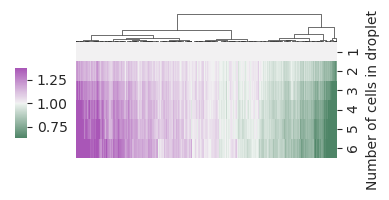

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the custom colormap
cmap = sns.diverging_palette(145, 300, s=60, as_cmap=True)

# Create the clustermap with the specified modifications
g = sns.clustermap(mean_strat_expr.div(mean_strat_expr.loc[1]), 
                   col_linkage=Z_ward, 
                   robust=True, 
                   row_cluster=False, 
                   center=1, 
                   figsize=[4, 1.75],
                   cmap=cmap,
                   xticklabels=[],
                   yticklabels=[1,2,3,4,5,6],
                   cbar_pos=(0, .2, .03, .4))

# Change the row label
g.ax_heatmap.set_ylabel("Number of cells in droplet")

# Resize the colorbar to match the height of the clustermap
g.cax.set_position([.05, .2, .03, .4])

g.savefig('20240407_probability_of_detection_of_different_genes.pdf', bbox_inches='tight')

In [23]:
raw_expr = get_stratified_expression(full_pop, ['number_of_cells'], cells='gem_group==1', genes='mean > 1', gene_names=True)
q_strat_expr = get_stratified_expression(full_pop, ['number_of_cells'], cells='gem_group==1', genes='mean > 1', normalized=True, normalized_name='q', gene_names=True)

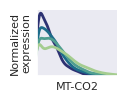

In [63]:
expr_df = strat_expr['MT-CO2'].reset_index(level=0)

g = sns.displot(expr_df.query('number_of_cells <= 4'),
                x='MT-CO2', hue='number_of_cells', palette='crest', kind='kde', common_norm=False,
                height=1, aspect=1.25, linewidth=2, legend=False)

g.set(xticks=[], yticks=[])  # Remove x-axis and y-axis tick labels
plt.xlabel('MT-CO2', fontsize=8)
plt.ylabel('Normalized\nexpression', fontsize=8)

plt.xlim([0, 0.005])
plt.tight_layout()
plt.savefig('20240407_MT-CO2_normalized_expression.pdf', bbox_inches='tight')

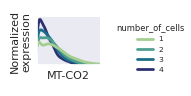

In [64]:
expr_df = strat_expr['MT-CO2'].reset_index(level=0)

g = sns.displot(expr_df.query('number_of_cells <= 4'),
                x='MT-CO2', hue='number_of_cells', palette='crest', kind='kde', common_norm=False,
                height=1, aspect=1.25, linewidth=2, legend=True)

g.set(xticks=[], yticks=[])  # Remove x-axis and y-axis tick labels
plt.xlabel('MT-CO2', fontsize=8)
plt.ylabel('Normalized\nexpression', fontsize=8)

plt.xlim([0, 0.005])
#plt.tight_layout()
plt.savefig('20240407_MT-CO2_normalized_expression_legend.pdf', bbox_inches='tight')

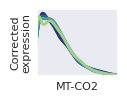

In [65]:
expr_df = q_strat_expr['MT-CO2'].reset_index(level=0)

g = sns.displot(expr_df.query('number_of_cells <= 4'),
                x='MT-CO2', hue='number_of_cells', palette='crest', kind='kde', common_norm=False,
                height=1, aspect=1.25, linewidth=2, legend=False)

g.set(xticks=[], yticks=[])  # Remove x-axis and y-axis tick labels
plt.xlabel('MT-CO2', fontsize=8)
plt.ylabel('Corrected\nexpression', fontsize=8)

plt.xlim([0, 0.005])
plt.tight_layout()
plt.savefig('20240407_MT-CO2_corrected_expression.pdf', bbox_inches='tight')

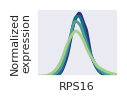

In [66]:
expr_df = strat_expr['RPS16'].reset_index(level=0)

g = sns.displot(expr_df.query('number_of_cells <= 4'),
                x='RPS16', hue='number_of_cells', palette='crest', kind='kde', common_norm=False,
                height=1, aspect=1.25, linewidth=2, legend=False)

g.set(xticks=[], yticks=[])  # Remove x-axis and y-axis tick labels
plt.xlabel('RPS16', fontsize=8)
plt.ylabel('Normalized\nexpression', fontsize=8)

plt.xlim([0, 0.005])
plt.tight_layout()
plt.savefig('20240407_RPS16_normalized_expression.pdf', bbox_inches='tight')

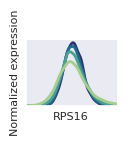

In [67]:
expr_df = q_strat_expr['RPS16'].reset_index(level=0)

g = sns.displot(expr_df.query('number_of_cells <= 4'),
                x='RPS16', hue='number_of_cells', palette='crest', kind='kde', common_norm=False,
                height=1, aspect=1.25, linewidth=2, legend=False)

g.set(xticks=[], yticks=[])  # Remove x-axis and y-axis tick labels
plt.xlabel('RPS16', fontsize=8)
plt.ylabel('Normalized expression', fontsize=8)

plt.xlim([0, 0.005])
plt.tight_layout()
plt.show()

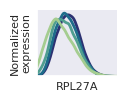

In [68]:
expr_df = strat_expr['RPL27A'].reset_index(level=0)

g = sns.displot(expr_df.query('number_of_cells <= 4'),
                x='RPL27A', hue='number_of_cells', palette='crest', kind='kde', common_norm=False,
                height=1, aspect=1.25, linewidth=2, legend=False)

g.set(xticks=[], yticks=[])  # Remove x-axis and y-axis tick labels
plt.xlabel('RPL27A', fontsize=8)
plt.ylabel('Normalized\nexpression', fontsize=8)

plt.xlim([0, 0.005])
plt.tight_layout()
plt.savefig('20240407_RPL27A_normalized_expression.pdf', bbox_inches='tight')

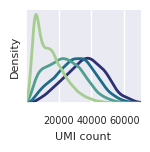

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

df = full_pop.cells.query('gem_group==1 and number_of_cells <= 4')[['UMI_count', 'number_of_cells', 'pairwise_UMI_count']]
df.columns = ['UMI count', 'number of cells in droplet', 'predicted UMI count']

g = sns.displot(df,
                x='UMI count', hue='number of cells in droplet', palette='crest', kind='kde', common_norm=False,
                height=1.5, aspect=1, linewidth=2, legend=False)

g.set(xticks=[20000, 40000, 60000], yticks=[])  # Remove y-axis tick labels

# Set the axis font size and tick label font size
plt.xlabel('UMI count', fontsize=8)
plt.ylabel('Density', fontsize=8)
plt.xticks(fontsize=7)

plt.xlim([0, 70000])
plt.tight_layout()
plt.savefig('20240407_raw_UMI_count_distributions.pdf', bbox_inches='tight')

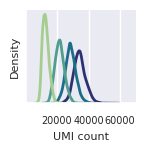

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

df = full_pop.cells.query('gem_group==1 and number_of_cells <= 4')[['UMI_count', 'number_of_cells', 'pairwise_UMI_count']]
df.columns = ['UMI count', 'number of cells in droplet', 'predicted UMI count']

g = sns.displot(df,
                x='predicted UMI count', hue='number of cells in droplet', palette='crest', kind='kde', common_norm=False,
                height=1.5, aspect=1, linewidth=2, legend=False)

g.set(xticks=[20000, 40000, 60000], yticks=[])  # Remove y-axis tick labels

# Set the axis font size and tick label font size
plt.xlabel('UMI count', fontsize=8)
plt.ylabel('Density', fontsize=8)
plt.xticks(fontsize=7)

plt.xlim([0, 70000])
plt.tight_layout()
plt.savefig('20240407_compensated_UMI_count_distributions.pdf', bbox_inches='tight')

# Setup for different benchmarking experiments

In [72]:
# Task 1: Only use multiplets of various varieties
# Task 2: Subsampling. Sample to same number of cells singlets vs. singlets + multiplets.

In [24]:
cell_subset = dict()
names = {2: 'doublets', 3: 'triplets', 4: 'quadruplets'}

for num in [2,3,4]:
    cell_subset['equal_cells_' + names[num]] = full_pop.cells[full_pop.cells['number_of_cells']==num].sample(n=int(16800/num), random_state=100).index

for num in [2]:
    cell_subset['1.25x_cells_' + names[num]] = full_pop.cells[full_pop.cells['number_of_cells']==num].sample(n=int(16800/num*1.25), random_state=100).index     
    
for num in [2,3]:
    cell_subset['1.5x_cells_' + names[num]] = full_pop.cells[full_pop.cells['number_of_cells']==num].sample(n=int(16800*1.5/num), random_state=100).index      
    
for num in [2,3]:
    cell_subset['1.75x_cells_' + names[num]] = full_pop.cells[full_pop.cells['number_of_cells']==num].sample(n=int(16800*1.75/num), random_state=100).index      
    
for num in [2]:
    cell_subset['2x_cells_' + names[num]] = full_pop.cells[full_pop.cells['number_of_cells']==num].sample(n=int(16800*2/num), random_state=100).index

In [25]:
initial_singlets = full_pop.cells.query('number_of_cells==1')
targeted_singlets = full_pop.cells[full_pop.cells['number_of_cells']==1].sample(n=16800, random_state=100).index
remaining_singlets = full_pop.cells.loc[np.setdiff1d(full_pop.cells.index, targeted_singlets)].query('number_of_cells==1').index
multiplets = full_pop.cells.query('number_of_cells > 1')
 
singlet_to_multiplet_ratio = len(initial_singlets)/len(multiplets.index)
print(f'the ratio of singlets to multiplets in this dataset is: {singlet_to_multiplet_ratio}')

#select the multiplets
selected_multiplets = multiplets.sample(int(len(remaining_singlets)/singlet_to_multiplet_ratio), random_state=23)

#index of selected remaining cells
total_remaining = remaining_singlets.append(selected_multiplets.index)
remaining_cells = full_pop.cells.loc[total_remaining]
print(f'after removing selected singlets and rebalancing the ratio there are {len(total_remaining)} remaining droplets')

# print('We are redefining multiplet pop to the remaining droplets')
# multiplet_pop = full_pop.subpopulation(cells = total_remaining)

the ratio of singlets to multiplets in this dataset is: 0.8890325986538208
after removing selected singlets and rebalancing the ratio there are 35869 remaining droplets


In [22]:
len(initial_singlets)

33681

In [75]:
len(remaining_singlets)

16881

In [76]:
remaining_cells.groupby('number_of_cells').size()

number_of_cells
1    16881
2     9727
3     5221
4     2409
5     1135
6      496
dtype: int64

In [77]:
full_pop.cells.groupby('number_of_cells').size()/remaining_cells.groupby('number_of_cells').size()

number_of_cells
1    1.995202
2    2.005963
3    1.967439
4    2.014944
5    1.970925
6    2.036290
dtype: float64

In [26]:
subsample_rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

subsampled_cells = dict()

for rate in subsample_rates:
    subsampled_cells[rate] = remaining_cells.sample(frac=rate, random_state=23).index

In [27]:
downsampling_rates = [0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1 ]

downsampled_singlets = dict()

for rate in downsampling_rates:
    downsampled_singlets[rate] = remaining_cells.query('number_of_cells==1').sample(frac=rate, random_state=23).index

# Load identity calls

In [24]:
control_guides = full_pop.cells.query('control')['guide_identity'].unique()
off_target_controls = np.setdiff1d(full_pop.cells.query('guide_target=="non-targeting"')['guide_identity'].unique(), control_guides)

In [25]:
off_target_mapper = pd.Series(map(lambda x: x.replace('non-targeting', 'off-target'), off_target_controls), index=off_target_controls)

In [ ]:
# Normalized design matrix for stably captured gene normalization and z-normalization regression

# Different design matrix choices

In [28]:
design_matrix = pd.read_csv(EXPERIMENT+'240129_rpe1_e150_maxol_crispri_full_design_matrix_guide_identity.csv',
                              index_col = 'cell_barcode')

design_matrix.columns = design_matrix.columns.map(lambda x: off_target_mapper.get(x, x))
design_matrix = design_matrix.loc[full_pop.cells.index]

design_matrix = design_matrix.T
design_matrix['control'] = design_matrix.index.map(lambda x: 'control' if 'non-targeting' in x else x)
design_matrix = design_matrix.groupby('control').sum()
design_matrix = design_matrix.T

norm_design_matrix = design_matrix.div(design_matrix.sum(axis=1), axis=0)
cell_counts = design_matrix.sum(axis=1)
non_control_counts = design_matrix.loc[:, design_matrix.columns!='control'].sum(axis=1)

In [29]:
delta_design_matrix = design_matrix.copy()
delta_design_matrix['control'] = delta_design_matrix['control'] + non_control_counts

In [30]:
UMI_counts = full_pop.cells.groupby(['gem_group', 'number_of_cells'])['UMI_count'].median()
#factors = (UMI_counts/UMI_counts.xs(1, level=1)).groupby(level=1).mean()
factors = (UMI_counts/UMI_counts.xs(1, level=1))

# cell_factors = cell_counts.map(factors).loc[full_pop.cells.index]
cell_factors = full_pop.cells.apply(lambda x: factors.loc[(x['gem_group'], x['number_of_cells'])], axis=1)

In [31]:
delta_mod_design_matrix = delta_design_matrix.div(cell_factors, axis=0)

In [34]:
design_matrices = dict()

In [65]:
design_matrices['raw'] = design_matrix
design_matrices['delta'] = delta_design_matrix
design_matrices['norm'] = norm_design_matrix
design_matrices['delta_mod'] = delta_mod_design_matrix

In [ ]:
# different normalization recipes used in benchmarking

In [36]:
recipes = dict()

# unnormalized expression matrix

recipes['delta-unnorm'] = \
{'design_matrix': 'delta',
 'expression_matrix': 'unnormalized',
 'postnorm': 'non_control_std'}

# unnormalized expression matrix taking into account droplets
# used for newly expressed genes and on target activation analyses

recipes['delta_mod-unnorm'] = \
{'design_matrix': 'delta_mod',
 'expression_matrix': 'unnormalized',
 'postnorm': 'non_control_std'}

# just equalize UMI counts to 14500

recipes['delta_norm-equal_UMI'] = \
{'design_matrix': 'delta_norm',
 'expression_matrix': 'equal_UMI',
 'postnorm': 'non_control_std'}

# z-normalization per gemgroup
# our baseline comparison in the paper

recipes['norm-gemgroup'] = \
{'design_matrix': 'norm',
 'expression_matrix': 'gemgroup',
 'postnorm': 'non_control'}

# the stably captured genes normalization used in the paper

recipes['norm-trim_offset_norm_p'] = \
{'design_matrix': 'norm',
 'expression_matrix': 'trim_offset_norm_p',
 'postnorm': 'non_control'}

# Performing regressions and benchmarking

In [40]:
import warnings
from scipy.linalg import lstsq
from scipy.stats import t as t_stat
from joblib import Parallel, delayed

def compute_column(X, y, coef, ss_res, rank, XtX_inv, constant, gene_name):
    n = X.shape[0]
    
    # Degrees of freedom
    df_model = rank - constant
    df_resid = n - rank
    ss_tot = y @ y
        
    mse = ss_res / df_resid
    beta_var = mse * XtX_inv
    beta_se = np.sqrt(beta_var)

    # Compute T and p-values
    T = coef / beta_se
    pval = 2 * t_stat.sf(np.fabs(T), df_resid)

    out = pd.DataFrame([pd.Series(coef, index=X.columns, name='coef'),
                        pd.Series(pval, index=X.columns, name='p')]).T
    if gene_name is not None:
        out['gene_name'] = gene_name

    return out

def least_squares(X, Y, coef_only=False, constant=False, XtX_inv=None, n_jobs=-1):
    """
    Perform ordinary least squares regression.
    
    Parameters:
    - X: DataFrame containing the independent variables.
    - Y: DataFrame containing the dependent variables.
    - coef_only: If True, returns only the coefficients.
    - constant: Boolean, indicating if there's a constant term in the regression.
    - n_jobs: Number of cores to use in parallel. -1 means using all processors.
    
    Returns:
    - Dictionary where each key corresponds to a dependent variable's column name and its associated value is the DataFrame containing coefficients and p-values for that dependent variable.
    """
    n = X.shape[0]

    # FIT LEAST SQUARES REGRESSION
    coef, ss_res, rank, _ = lstsq(X, Y, cond=None)
    
    calc_ss_res = False
    if rank < X.shape[1]:
        warnings.warn(
            "Design matrix supplied with `X` parameter is rank "
            f"deficient (rank {rank} with {X.shape[1]} columns). "
            "That means that one or more of the columns in `X` "
            "are a linear combination of one or more of the "
            "other columns."
        )
        calc_ss_res = True
        
    if coef_only:
        return coef

    if XtX_inv is None:
        XtX_inv = (np.linalg.pinv(X.T @ X).diagonal())

    if calc_ss_res:
        resid = Y.values - X.values @ coef
        ss_res = (resid**2).sum(axis=0)
    
    ss_res = pd.Series(ss_res, index=Y.columns)

    results = Parallel(n_jobs=n_jobs, verbose=10)(
        delayed(compute_column)(X, Y[col], coef[:, i], ss_res[col], rank, XtX_inv, constant, col)
        for i, col in enumerate(Y.columns)
    )
    
    results = pd.concat(results).pivot(columns='gene_name')
    return results['coef'], results['p']

In [41]:
control_cells = full_pop.cells['control']

In [42]:
from functools import reduce

In [43]:
non_control_perturbations = np.setdiff1d(design_matrix.columns,
                                         reduce(np.union1d,
                                                [['control'],
                                                 design_matrix.columns[design_matrix.columns.str.startswith('gem')], 
                                                 design_matrix.columns[design_matrix.columns.str.contains('off-target')]]))

In [45]:
# routine for computing comparisons between inferred coefficients or p-values

In [46]:
def compare_coefs(coefs, baseline_coefs, method='pearson', print_results=True, only_perturbations=True, name=None, p_compare=False):
    
    if only_perturbations:
        target_coefs = coefs.loc[non_control_perturbations].copy()
        compare_coefs = baseline_coefs.loc[non_control_perturbations].copy()
    else:
        target_coefs = coefs
        compare_coefs = baseline_coefs
    
    profile_corrs = target_coefs.corrwith(compare_coefs, method=method)
    gene_corrs = target_coefs.corrwith(compare_coefs, method=method, axis=1)
    
    pert_C = target_coefs.corr()
    baseline_C = compare_coefs.corr()
    
    corr_corrs = pert_C.corrwith(baseline_C, method=method)    
    
    overall_pairwise_corr = pert_C.stack().corr(baseline_C.stack(), method=method)
    overall_coefs_corr = target_coefs.stack().corr(compare_coefs.stack(), method=method)
    
    summary_stats = {
        'mean_profile_corr': profile_corrs.mean(),
        'median_profile_corr': profile_corrs.median(),
        'mean_gene_corr': gene_corrs.mean(),
        'median_gene_corr': gene_corrs.median(),
        'mean_corr_corr': corr_corrs.mean(),
        'median_corr_corr': corr_corrs.median(),
        'overall_pairwise_corr': overall_pairwise_corr,
        'overall_coefs_corr': overall_coefs_corr
    }
    
    if p_compare:
        counts = target_coefs.sum(axis=1)
        baseline_counts = compare_coefs.sum(axis=1)
        strong_perts = baseline_counts[baseline_counts > 30].index
        
        summary_stats['count_corr'] = counts.corr(baseline_counts, method='spearman')
        summary_stats['strong_count_corr'] = counts.loc[strong_perts].corr(baseline_counts.loc[strong_perts], method='spearman')
        
    if print_results:
        for key, value in summary_stats.items():
            print(f'{key.upper()}: {value:.3f}')

    return pd.Series(summary_stats, name=name)

In [47]:
# postprocessing of beta matrix (e.g. removing control guides or standardizing scales)

In [48]:
def postnorm(coefs, params):
    method = params['postnorm']
    expr = exprs[params['expression_matrix']]
    
    if method == 'none':
        return coefs
    elif method == 'non_control':
        norm_coefs = coefs.loc[non_control_perturbations].copy()
        return norm_coefs
    elif method == 'non_control_std':
        norm_coefs = coefs.loc[non_control_perturbations].copy()
        control_std = expr.loc[full_pop.cells['control']].std()
        return norm_coefs.div(control_std)
    elif method == 'non_control_z':
        norm_coefs = coefs.loc[non_control_perturbations].copy()
        control_std = expr.loc[full_pop.cells['control']].std()
        return (norm_coefs - coefs.loc['control']).div(control_std)

In [49]:
# code for running different benchmarking experiments

In [50]:
from perturbseq.differential_expression import _multi_test_correct

def run_recipe(name):
    
    comparisons = dict()
    adj_p_comparisons = dict()
    
    params = recipes[name]
    
    coefs = dict()
    norm_coefs = dict()
    ps = dict()
    adj_ps = dict()
    
    coefs['ground'], ps['ground'] = least_squares(design_matrices[params['design_matrix']].loc[targeted_singlets],
                                    exprs[params['expression_matrix']].loc[targeted_singlets],
                                    coef_only=False, n_jobs=10)
    norm_coefs['ground'] = postnorm(coefs['ground'], params)
    
    adj_ps['ground'] = ps['ground'].T.apply(lambda x: _multi_test_correct(x, 0.05, 'fdr_bh')).T
    
    coefs['test'], ps['test'] = least_squares(design_matrices[params['design_matrix']].loc[remaining_singlets],
                                    exprs[params['expression_matrix']].loc[remaining_singlets],
                                    coef_only=False, n_jobs=10)
    norm_coefs['test'] = postnorm(coefs['test'], params)
    
    adj_ps['test'] = ps['test'].T.apply(lambda x: _multi_test_correct(x, 0.05, 'fdr_bh')).T
    
    comparisons['baseline'] = compare_coefs(norm_coefs['ground'], norm_coefs['test'])
    
    adj_p_comparisons['baseline'] = compare_coefs(adj_ps['ground'], adj_ps['test'], p_compare=True, method='spearman')
        
    for rate, cells in subsampled_cells.items():
        if 'subsample_query' in params.keys():
            filtered_cells = full_pop.cells.query(params['subsample_query']).index
            cells = np.intersect1d(cells, filtered_cells)
        
        coefs[rate], ps[rate] = least_squares(design_matrices[params['design_matrix']].loc[cells],
                                              exprs[params['expression_matrix']].loc[cells],
                                              coef_only=False, n_jobs=10)
        norm_coefs[rate] = postnorm(coefs[rate], params)
        
        adj_ps[rate] = ps[rate].T.apply(lambda x: _multi_test_correct(x, 0.05, 'fdr_bh')).T
        
        comparisons[rate] = compare_coefs(norm_coefs['ground'], norm_coefs[rate])
        adj_p_comparisons[rate] = compare_coefs(adj_ps['ground'], adj_ps[rate], p_compare=True, method='spearman')
        
    results = {
        'name': name,
        'coef': coefs,
        'norm_coef': norm_coefs,
        'p': ps,
        'adj_p': adj_ps,
        'comparison': pd.DataFrame(comparisons),
        'adj_p_comparison': pd.DataFrame(adj_p_comparisons)
    }
        
    return results

In [51]:
def run_recipe_downsampled_singlets(name):
    
    comparisons = dict()
    adj_p_comparisons = dict()
    
    params = recipes[name]
    
    coefs = dict()
    norm_coefs = dict()
    ps = dict()
    adj_ps = dict()
    
    coefs['ground'], ps['ground'] = least_squares(design_matrices[params['design_matrix']].loc[targeted_singlets],
                                    exprs[params['expression_matrix']].loc[targeted_singlets],
                                    coef_only=False, n_jobs=10)
    norm_coefs['ground'] = postnorm(coefs['ground'], params)
    
    adj_ps['ground'] = ps['ground'].T.apply(lambda x: _multi_test_correct(x, 0.05, 'fdr_bh')).T
    
    coefs['test'], ps['test'] = least_squares(design_matrices[params['design_matrix']].loc[remaining_singlets],
                                    exprs[params['expression_matrix']].loc[remaining_singlets],
                                    coef_only=False, n_jobs=10)
    norm_coefs['test'] = postnorm(coefs['test'], params)
    
    adj_ps['test'] = ps['test'].T.apply(lambda x: _multi_test_correct(x, 0.05, 'fdr_bh')).T
    
    comparisons['baseline'] = compare_coefs(norm_coefs['ground'], norm_coefs['test'])
    
    adj_p_comparisons['baseline'] = compare_coefs(adj_ps['ground'], adj_ps['test'], p_compare=True, method='spearman')
        
    for rate, cells in downsampled_singlets.items():
        if 'subsample_query' in params.keys():
            filtered_cells = full_pop.cells.query(params['subsample_query']).index
            cells = np.intersect1d(cells, filtered_cells)
        
        coefs[rate], ps[rate] = least_squares(design_matrices[params['design_matrix']].loc[cells],
                                              exprs[params['expression_matrix']].loc[cells],
                                              coef_only=False, n_jobs=10)
        norm_coefs[rate] = postnorm(coefs[rate], params)
        
        adj_ps[rate] = ps[rate].T.apply(lambda x: _multi_test_correct(x, 0.05, 'fdr_bh')).T
        
        comparisons[rate] = compare_coefs(norm_coefs['ground'], norm_coefs[rate])
        adj_p_comparisons[rate] = compare_coefs(adj_ps['ground'], adj_ps[rate], p_compare=True, method='spearman')
        
    results = {
        'name': name,
        'coef': coefs,
        'norm_coef': norm_coefs,
        'p': ps,
        'adj_p': adj_ps,
        'comparison': pd.DataFrame(comparisons),
        'adj_p_comparison': pd.DataFrame(adj_p_comparisons)
    }
        
    return results

In [52]:
def reanalyze_results(results, mean_threshold):
    columns = full_pop.genes.query('mean > @mean_threshold').index
    
    # Subset the norm_coefs and adj_ps for 'ground' and other keys
    norm_coefs_subset = {k: v[columns] for k, v in results['norm_coefs'].items()}
    adj_ps_subset = {k: v[columns] < 0.01 for k, v in results['adj_ps'].items()}

    reanalyzed_comparisons = dict()
    reanalyzed_adj_p_comparisons = dict()

    for key in results['norm_coefs'].keys():
        if key == 'ground':
            continue  # skip 'ground' since it's used as a baseline in comparisons

        # Compare using the subsetted data
        reanalyzed_comparisons[key] = compare_coefs(norm_coefs_subset['ground'], norm_coefs_subset[key])
        reanalyzed_adj_p_comparisons[key] = compare_coefs(adj_ps_subset['ground'], adj_ps_subset[key], p_compare=True)

    reanalyzed_results = {
        'name': results['name'],
        'comparison': pd.DataFrame(reanalyzed_comparisons),
        'adj_p_comparison': pd.DataFrame(reanalyzed_adj_p_comparisons)
    }

    return reanalyzed_results

In [53]:
def run_recipe_multiplets(name):
    
    comparisons = dict()
    adj_p_comparisons = dict()
    
    params = recipes[name]
    
    coefs = dict()
    norm_coefs = dict()
    ps = dict()
    adj_ps = dict()
    
    coefs['ground'], ps['ground'] = least_squares(design_matrices[params['design_matrix']].loc[targeted_singlets],
                                    exprs[params['expression_matrix']].loc[targeted_singlets],
                                    coef_only=False, n_jobs=10)
    norm_coefs['ground'] = postnorm(coefs['ground'], params)
    
    adj_ps['ground'] = ps['ground'].T.apply(lambda x: _multi_test_correct(x, 0.05, 'fdr_bh')).T
    
    coefs['test'], ps['test'] = least_squares(design_matrices[params['design_matrix']].loc[remaining_singlets],
                                    exprs[params['expression_matrix']].loc[remaining_singlets],
                                    coef_only=False, n_jobs=10)
    norm_coefs['test'] = postnorm(coefs['test'], params)
    
    adj_ps['test'] = ps['test'].T.apply(lambda x: _multi_test_correct(x, 0.05, 'fdr_bh')).T
    
    comparisons['baseline'] = compare_coefs(norm_coefs['ground'], norm_coefs['test'])
    
    adj_p_comparisons['baseline'] = compare_coefs(adj_ps['ground'], adj_ps['test'], p_compare=True, method='spearman')
        
    for rate, cells in cell_subset.items():        
        coefs[rate], ps[rate] = least_squares(design_matrices[params['design_matrix']].loc[cells],
                                              exprs[params['expression_matrix']].loc[cells],
                                              coef_only=False, n_jobs=10)
        norm_coefs[rate] = postnorm(coefs[rate], params)
        
        adj_ps[rate] = ps[rate].T.apply(lambda x: _multi_test_correct(x, 0.05, 'fdr_bh')).T
        
        comparisons[rate] = compare_coefs(norm_coefs['ground'], norm_coefs[rate])
        adj_p_comparisons[rate] = compare_coefs(adj_ps['ground'], adj_ps[rate], p_compare=True, method='spearman')
        
    results = {
        'name': name,
        'coef': coefs,
        'norm_coef': norm_coefs,
        'p': ps,
        'adj_p': adj_ps,
        'comparison': pd.DataFrame(comparisons),
        'adj_p_comparison': pd.DataFrame(adj_p_comparisons)
    }
        
    return results

In [54]:
def run_recipe_full(name):
    
    comparisons = dict()
    adj_p_comparisons = dict()
    
    params = recipes[name]
    
    coefs = dict()
    norm_coefs = dict()
    ps = dict()
    adj_ps = dict()
    
    coefs['full'], ps['full'] = least_squares(design_matrices[params['design_matrix']],
                                    exprs[params['expression_matrix']],
                                    coef_only=False, n_jobs=10)
    norm_coefs['full'] = postnorm(coefs['full'], params)
    adj_ps['full'] = ps['full'].T.apply(lambda x: _multi_test_correct(x, 0.05, 'fdr_bh')).T

    
    singlets = full_pop.cells.query('number_of_cells==1').index    
    coefs['singlets'], ps['singlets'] = least_squares(design_matrices[params['design_matrix']].loc[singlets],
                                    exprs[params['expression_matrix']].loc[singlets],
                                    coef_only=False, n_jobs=10)
    norm_coefs['singlets'] = postnorm(coefs['singlets'], params)
    adj_ps['singlets'] = ps['singlets'].T.apply(lambda x: _multi_test_correct(x, 0.05, 'fdr_bh')).T
        
    comparisons['full_to_singlets'] = compare_coefs(norm_coefs['full'], norm_coefs['singlets'])
    adj_p_comparisons['full_to_singlets'] = compare_coefs(adj_ps['full'], adj_ps['singlets'], p_compare=True, method='spearman')
        
    results = {
        'name': name,
        'coef': coefs,
        'norm_coef': norm_coefs,
        'p': ps,
        'adj_p': adj_ps,
        'comparison': pd.DataFrame(comparisons),
        'adj_p_comparison': pd.DataFrame(adj_p_comparisons)
    }
        
    return results

In [55]:
import pickle

In [60]:
exprs = dict()

exprs['unnormalized'] = full_pop.where(genes='mean > 1')
exprs['equal_UMI'] = full_pop.where(genes='mean > 1', normalized=True, normalized_name='equal_UMI')
exprs['trim_offset_norm_p'] = full_pop.where(genes='mean > 1', normalized=True, normalized_name='trim_offset_norm_p')
exprs['gemgroup'] = full_pop.where(genes='mean > 1', normalized=True, normalized_name='gemgroup')

# Code for running benchmarking experiments and saving/loading results

In [ ]:
for name in recipes.keys():
    results = run_recipe(name)
    multiplet_results = run_recipe_multiplets(name)
    full_results = run_recipe_full(name)
    
    master_results = {
    'single': results,
    'multiplet': multiplet_results,
    'full': full_results
    }

    with open('./benchmarks/' + name + '-mean_1' + '.pkl', 'wb') as file:
        pickle.dump(master_results, file)

In [21]:
def load_benchmark_results(directory, suffix):
    results_dict = {}
    for filename in os.listdir(directory):
        if filename.endswith(suffix + '.pkl'):
            name = filename.split(suffix)[0]  # Extracting the "name" portion before the suffix
            with open(os.path.join(directory, filename), 'rb') as file:
                results_dict[name] = pickle.load(file)
    return results_dict

# Example usage
directory = './benchmarks/'
suffix = '-mean_1'
benchmark_results = load_benchmark_results(directory, suffix)

In [22]:
def split_benchmark_results(benchmark_results):
    single_results = {}
    multiplet_results = {}
    full_results = {}

    for name, data in benchmark_results.items():
        if 'single' in data:
            single_results[name] = data['single']
        if 'multiplet' in data:
            multiplet_results[name] = data['multiplet']
        if 'full' in data:
            full_results[name] = data['full']

    return single_results, multiplet_results, full_results

# Example usage
single_results, multiplet_results, full_results = split_benchmark_results(benchmark_results)

# Producing figures showing comparisons

In [29]:
droplet_size_mapper = {name: len(cells) for name, cells in subsampled_cells.items()}

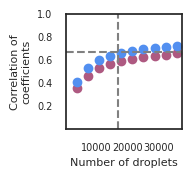

In [331]:
baseline_result = single_results['norm-trim_offset_norm_p']['comparison'].loc['overall_coefs_corr', 'baseline']
baseline_number = len(remaining_singlets)

plt.figure(figsize=(1.5, 1.5))

results = single_results['norm-gemgroup']['comparison'].iloc[:, 1:].loc['overall_coefs_corr']
results.index = results.index.map(droplet_size_mapper)

plt.scatter(results.index, results, color='#AE5981')

results = single_results['norm-trim_offset_norm_p']['comparison'].iloc[:, 1:].loc['overall_coefs_corr']
results.index = results.index.map(droplet_size_mapper)

plt.scatter(results.index, results, color='#528FF0')

# Plot the dashed horizontal line at baseline_result
plt.axhline(y=baseline_result, color='gray', linestyle='--', linewidth=1.5)

# Plot the dashed vertical line at baseline_number
plt.axvline(x=baseline_number, color='gray', linestyle='--', linewidth=1.5)

# Set the x-limit and y-limit of the plot
plt.xlim(left=0)
plt.ylim([0,1])

plt.xticks(np.arange(10000, 40000, 10000))
plt.yticks(np.arange(0.2, 1.2, 0.2))

plt.tick_params(axis='both', labelsize=7)

plt.xlabel('Number of droplets', fontsize=8)
plt.ylabel('Correlation of\ncoefficients', fontsize=8)

plt.savefig('20240408_correlation_of_coefficients_vs_gemgroup.pdf', bbox_inches='tight')

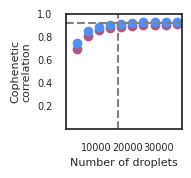

In [332]:
baseline_result = single_results['norm-trim_offset_norm_p']['comparison'].loc['overall_pairwise_corr', 'baseline']
baseline_number = len(remaining_singlets)

plt.figure(figsize=(1.5, 1.5))

results = single_results['norm-gemgroup']['comparison'].iloc[:, 1:].loc['overall_pairwise_corr']
results.index = results.index.map(droplet_size_mapper)

plt.scatter(results.index, results, color='#AE5981')

results = single_results['norm-trim_offset_norm_p']['comparison'].iloc[:, 1:].loc['overall_pairwise_corr']
results.index = results.index.map(droplet_size_mapper)

plt.scatter(results.index, results, color='#528FF0')

# Plot the dashed horizontal line at baseline_result
plt.axhline(y=baseline_result, color='gray', linestyle='--', linewidth=1.5)

# Plot the dashed vertical line at baseline_number
plt.axvline(x=baseline_number, color='gray', linestyle='--', linewidth=1.5)

# Set the x-limit and y-limit of the plot
plt.xlim(left=0)
plt.ylim([0,1])

plt.xticks(np.arange(10000, 40000, 10000))
plt.yticks(np.arange(0.2, 1.2, 0.2))

plt.tick_params(axis='both', labelsize=7)

plt.xlabel('Number of droplets', fontsize=8)
plt.ylabel('Cophenetic\ncorrelation', fontsize=8)

plt.savefig('20240408_cophenetic_correlation_vs_gemgroup.pdf', bbox_inches='tight')

## Calibration curve relative to downsampled singlets

In [109]:
downsampled_singlet_results = run_recipe_downsampled_singlets('norm-trim_offset_norm_p')

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    2.9s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    3.0s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    3.1s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    3.2s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    3.4s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:    3.6s
[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed:    3.8s
[Parallel(n_jobs=10)]: Done  93 tasks      | elapsed:    4.0s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    4.2s
[Parallel(n_jobs=10)]: Done 125 tasks      | elapsed:    4.5s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:    4.7s
[Parallel(n_jobs=10)]: Done 161 tasks      | elapsed:    5.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    5.2s
[Parallel(n_jobs=10)]: Done 201 tasks      | elapsed:  

MEAN_PROFILE_CORR: 0.449
MEDIAN_PROFILE_CORR: 0.442
MEAN_GENE_CORR: 0.606
MEDIAN_GENE_CORR: 0.662
MEAN_CORR_CORR: 0.833
MEDIAN_CORR_CORR: 0.903
OVERALL_PAIRWISE_CORR: 0.918
OVERALL_COEFS_CORR: 0.666
MEAN_PROFILE_CORR: 0.472
MEDIAN_PROFILE_CORR: 0.455
MEAN_GENE_CORR: 0.348
MEDIAN_GENE_CORR: 0.357
MEAN_CORR_CORR: 0.564
MEDIAN_CORR_CORR: 0.581
OVERALL_PAIRWISE_CORR: 0.650
OVERALL_COEFS_CORR: 0.544
COUNT_CORR: 0.860
STRONG_COUNT_CORR: 0.860


/tmp/ipykernel_596184/2808016983.py:52: UserWarning: Design matrix supplied with `X` parameter is rank deficient (rank 140 with 142 columns). That means that one or more of the columns in `X` are a linear combination of one or more of the other columns.
  warnings.warn(
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Batch computation too fast (0.03086376190185547s.) Setting batch_size=2.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done  22 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Batch computation too fast (0.10147452354431152s.) Setting batch_size=4.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done  64 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Batch computation too fast (0.12590622901916504s.) Setting batch_size=8.
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed: 

/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/280

/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/280

/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/280

/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/280

/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/280

/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/280

/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/280

/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/280

/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/280

/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/280

/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/280

/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/280

/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/280

/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/280

/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/280

/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/280

[Parallel(n_jobs=10)]: Done 3115 tasks      | elapsed:    4.5s
[Parallel(n_jobs=10)]: Done 3142 tasks      | elapsed:    4.6s
[Parallel(n_jobs=10)]: Done 3163 out of 3163 | elapsed:    4.7s finished


MEAN_PROFILE_CORR: 0.230
MEDIAN_PROFILE_CORR: 0.208
MEAN_GENE_CORR: 0.316
MEDIAN_GENE_CORR: 0.341
MEAN_CORR_CORR: 0.515
MEDIAN_CORR_CORR: 0.561
OVERALL_PAIRWISE_CORR: 0.610
OVERALL_COEFS_CORR: 0.321


/data/norman/tmn/envs/analysis38/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


MEAN_PROFILE_CORR: 0.274
MEDIAN_PROFILE_CORR: 0.269
MEAN_GENE_CORR: 0.105
MEDIAN_GENE_CORR: 0.084
MEAN_CORR_CORR: 0.281
MEDIAN_CORR_CORR: 0.271
OVERALL_PAIRWISE_CORR: 0.337
OVERALL_COEFS_CORR: 0.277
COUNT_CORR: 0.517
STRONG_COUNT_CORR: 0.548


/tmp/ipykernel_596184/2808016983.py:52: UserWarning: Design matrix supplied with `X` parameter is rank deficient (rank 141 with 142 columns). That means that one or more of the columns in `X` are a linear combination of one or more of the other columns.
  warnings.warn(
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Batch computation too fast (0.031129121780395508s.) Setting batch_size=2.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done  22 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Batch computation too fast (0.1414775848388672s.) Setting batch_size=4.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.2s
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_59

kernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Batch computation too fast (0.17439842224121094s.) Setting batch_size=16.
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.5s
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipy

/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/28080

/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/280

/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/28080

/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/28080169

/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/28080169

/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/28080169

/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/28080169

[Parallel(n_jobs=10)]: Done 1900 tasks      | elapsed:    3.2s
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid 

/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/28080169

/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/28080169

/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/28080169

/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/28080169

[Parallel(n_jobs=10)]: Done 3063 tasks      | elapsed:    5.0s
[Parallel(n_jobs=10)]: Done 3088 tasks      | elapsed:    5.1s
[Parallel(n_jobs=10)]: Done 3115 tasks      | elapsed:    5.2s
[Parallel(n_jobs=10)]: Done 3142 tasks      | elapsed:    5.3s
[Parallel(n_jobs=10)]: Done 3163 out of 3163 | elapsed:    5.4s finished


MEAN_PROFILE_CORR: 0.262
MEDIAN_PROFILE_CORR: 0.238
MEAN_GENE_CORR: 0.368
MEDIAN_GENE_CORR: 0.381
MEAN_CORR_CORR: 0.613
MEDIAN_CORR_CORR: 0.681
OVERALL_PAIRWISE_CORR: 0.735
OVERALL_COEFS_CORR: 0.393


/data/norman/tmn/envs/analysis38/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


MEAN_PROFILE_CORR: 0.345
MEDIAN_PROFILE_CORR: 0.337
MEAN_GENE_CORR: 0.147
MEDIAN_GENE_CORR: 0.131
MEAN_CORR_CORR: 0.367
MEDIAN_CORR_CORR: 0.370
OVERALL_PAIRWISE_CORR: 0.436
OVERALL_COEFS_CORR: 0.361
COUNT_CORR: 0.629
STRONG_COUNT_CORR: 0.629


/tmp/ipykernel_596184/2808016983.py:52: UserWarning: Design matrix supplied with `X` parameter is rank deficient (rank 141 with 142 columns). That means that one or more of the columns in `X` are a linear combination of one or more of the other columns.
  warnings.warn(
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Batch computation too fast (0.03123331069946289s.) Setting batch_size=2.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done  22 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Batch computation too fast (0.12493753433227539s.) Setting batch_size=4.
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountere

[Parallel(n_jobs=10)]: Done  64 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Batch computation too fast (0.18785476684570312s.) Setting batch_size=8.
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.6s
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21:

[Parallel(n_jobs=10)]: Done 404 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 524 tasks      | elapsed:    1.2s
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tm

/tmp/ipyker[Parallel(n_jobs=10)]: Done 660 tasks      | elapsed:    1.4s
nel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid v

/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: inval[Parallel(n_jobs=10)]: Done 796 tasks      | elapsed:    1.7s
id value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid v

[Parallel(n_jobs=10)]: Done 948 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done 1100 tasks      | elapsed:    2.2s
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/t

[Parallel(n_jobs=10)]: Done 1268 tasks      | elapsed:    2.5s
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid 

/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/28080169

/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/28080169

/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/28080169

/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/28080169

/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/28080169

/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/28080169

/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/28080169

/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/28080169

/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/28080169

/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/28080169

MEAN_PROFILE_CORR: 0.279
MEDIAN_PROFILE_CORR: 0.257
MEAN_GENE_CORR: 0.399
MEDIAN_GENE_CORR: 0.397
MEAN_CORR_CORR: 0.659
MEDIAN_CORR_CORR: 0.734
OVERALL_PAIRWISE_CORR: 0.779
OVERALL_COEFS_CORR: 0.429


/data/norman/tmn/envs/analysis38/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


MEAN_PROFILE_CORR: 0.346
MEDIAN_PROFILE_CORR: 0.333
MEAN_GENE_CORR: 0.172
MEDIAN_GENE_CORR: 0.149
MEAN_CORR_CORR: 0.399
MEDIAN_CORR_CORR: 0.401
OVERALL_PAIRWISE_CORR: 0.472
OVERALL_COEFS_CORR: 0.370
COUNT_CORR: 0.643
STRONG_COUNT_CORR: 0.643


/tmp/ipykernel_596184/2808016983.py:52: UserWarning: Design matrix supplied with `X` parameter is rank deficient (rank 141 with 142 columns). That means that one or more of the columns in `X` are a linear combination of one or more of the other columns.
  warnings.warn(
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Batch computation too fast (0.019239187240600586s.) Setting batch_size=2.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done  22 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Batch computation too fast (0.10178351402282715s.) Setting batch_size=4.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done  64 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Batch computation too fast (0.12914800643920898s.) Setting batch_size=8.
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:

/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/28080169

/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/28080169

/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/28080169

/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/28080169

/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/28080169

/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/28080169

/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/28080169

/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/28080169

/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/28080169

/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/28080169

/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/28080169

/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/28080169

[Parallel(n_jobs=10)]: Done 2940 tasks      | elapsed:    4.7s
[Parallel(n_jobs=10)]: Done 3038 tasks      | elapsed:    4.9s
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/

[Parallel(n_jobs=10)]: Done 3115 tasks      | elapsed:    5.3s
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid 

MEAN_PROFILE_CORR: 0.292
MEDIAN_PROFILE_CORR: 0.266
MEAN_GENE_CORR: 0.429
MEDIAN_GENE_CORR: 0.450
MEAN_CORR_CORR: 0.680
MEDIAN_CORR_CORR: 0.749
OVERALL_PAIRWISE_CORR: 0.795
OVERALL_COEFS_CORR: 0.459
MEAN_PROFILE_CORR: 0.365
MEDIAN_PROFILE_CORR: 0.350
MEAN_GENE_CORR: 0.190
MEDIAN_GENE_CORR: 0.176
MEAN_CORR_CORR: 0.426
MEDIAN_CORR_CORR: 0.428
OVERALL_PAIRWISE_CORR: 0.501
OVERALL_COEFS_CORR: 0.397
COUNT_CORR: 0.698
STRONG_COUNT_CORR: 0.698


/tmp/ipykernel_596184/2808016983.py:52: UserWarning: Design matrix supplied with `X` parameter is rank deficient (rank 141 with 142 columns). That means that one or more of the columns in `X` are a linear combination of one or more of the other columns.
  warnings.warn(
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Batch computation too fast (0.04821586608886719s.) Setting batch_size=2.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done  22 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Batch computation too fast (0.10665607452392578s.) Setting batch_size=4.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.2s
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596

/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/28080169

/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/28080169

/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/28080169

[Parallel(n_jobs=10)]: Done 660 tasks      | elapsed:    1.6s
[Parallel(n_jobs=10)]: Done 796 tasks      | elapsed:    1.8s
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tm

/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/28080169

/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/28080169

/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/28080169

[Parallel(n_jobs=10)]: Done 1436 tasks      | elapsed:    3.0s
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid 

/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/28080169

/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/28080169

[Parallel(n_jobs=10)]: Done 2004 tasks      | elapsed:    4.0s
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid 

/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/28080169

[Parallel(n_jobs=10)]: Done 2420 tasks      | elapsed:    5.1s
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid 

/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/28080169

/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/28080169

/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/28080169

[Parallel(n_jobs=10)]: Done 2868 tasks      | elapsed:    6.0s
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_596184/2808016983.py:21: RuntimeWarning: invalid 

[Parallel(n_jobs=10)]: Done 3093 tasks      | elapsed:    6.4s
[Parallel(n_jobs=10)]: Done 3131 tasks      | elapsed:    6.5s
[Parallel(n_jobs=10)]: Done 3163 out of 3163 | elapsed:    6.6s finished


MEAN_PROFILE_CORR: 0.312
MEDIAN_PROFILE_CORR: 0.284
MEAN_GENE_CORR: 0.455
MEDIAN_GENE_CORR: 0.484
MEAN_CORR_CORR: 0.707
MEDIAN_CORR_CORR: 0.777
OVERALL_PAIRWISE_CORR: 0.820
OVERALL_COEFS_CORR: 0.492
MEAN_PROFILE_CORR: 0.382
MEDIAN_PROFILE_CORR: 0.364
MEAN_GENE_CORR: 0.211
MEDIAN_GENE_CORR: 0.196
MEAN_CORR_CORR: 0.452
MEDIAN_CORR_CORR: 0.457
OVERALL_PAIRWISE_CORR: 0.530
OVERALL_COEFS_CORR: 0.423
COUNT_CORR: 0.701
STRONG_COUNT_CORR: 0.701


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Batch computation too fast (0.045823097229003906s.) Setting batch_size=2.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done  22 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Batch computation too fast (0.15641522407531738s.) Setting batch_size=4.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done  64 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Batch computation too fast (0.1786637306213379s.) Setting batch_size=8.
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Done 284 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 404 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done 524 tasks      | elapsed:    1.5s
[Parallel(n_job

MEAN_PROFILE_CORR: 0.338
MEDIAN_PROFILE_CORR: 0.312
MEAN_GENE_CORR: 0.482
MEDIAN_GENE_CORR: 0.505
MEAN_CORR_CORR: 0.732
MEDIAN_CORR_CORR: 0.806
OVERALL_PAIRWISE_CORR: 0.844
OVERALL_COEFS_CORR: 0.527
MEAN_PROFILE_CORR: 0.394
MEDIAN_PROFILE_CORR: 0.374
MEAN_GENE_CORR: 0.233
MEDIAN_GENE_CORR: 0.217
MEAN_CORR_CORR: 0.470
MEDIAN_CORR_CORR: 0.474
OVERALL_PAIRWISE_CORR: 0.548
OVERALL_COEFS_CORR: 0.441
COUNT_CORR: 0.742
STRONG_COUNT_CORR: 0.742


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Batch computation too fast (0.04205012321472168s.) Setting batch_size=2.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done  22 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Batch computation too fast (0.11951684951782227s.) Setting batch_size=4.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done  64 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Batch computation too fast (0.1580979824066162s.) Setting batch_size=8.
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.6s
[Parallel(n_jobs=10)]: Done 284 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 404 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 524 tasks      | elapsed:    1.3s
[Parallel(n_jobs

MEAN_PROFILE_CORR: 0.351
MEDIAN_PROFILE_CORR: 0.326
MEAN_GENE_CORR: 0.501
MEDIAN_GENE_CORR: 0.531
MEAN_CORR_CORR: 0.748
MEDIAN_CORR_CORR: 0.821
OVERALL_PAIRWISE_CORR: 0.857
OVERALL_COEFS_CORR: 0.546
MEAN_PROFILE_CORR: 0.398
MEDIAN_PROFILE_CORR: 0.376
MEAN_GENE_CORR: 0.247
MEDIAN_GENE_CORR: 0.227
MEAN_CORR_CORR: 0.485
MEDIAN_CORR_CORR: 0.493
OVERALL_PAIRWISE_CORR: 0.566
OVERALL_COEFS_CORR: 0.448
COUNT_CORR: 0.759
STRONG_COUNT_CORR: 0.759


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Batch computation too fast (0.040598154067993164s.) Setting batch_size=2.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done  22 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Batch computation too fast (0.11661815643310547s.) Setting batch_size=4.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done  64 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Batch computation too fast (0.1817607879638672s.) Setting batch_size=8.
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Done 284 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done 404 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done 524 tasks      | elapsed:    1.4s
[Parallel(n_job

MEAN_PROFILE_CORR: 0.365
MEDIAN_PROFILE_CORR: 0.339
MEAN_GENE_CORR: 0.517
MEDIAN_GENE_CORR: 0.550
MEAN_CORR_CORR: 0.767
MEDIAN_CORR_CORR: 0.838
OVERALL_PAIRWISE_CORR: 0.870
OVERALL_COEFS_CORR: 0.562
MEAN_PROFILE_CORR: 0.391
MEDIAN_PROFILE_CORR: 0.369
MEAN_GENE_CORR: 0.261
MEDIAN_GENE_CORR: 0.243
MEAN_CORR_CORR: 0.500
MEDIAN_CORR_CORR: 0.508
OVERALL_PAIRWISE_CORR: 0.580
OVERALL_COEFS_CORR: 0.443
COUNT_CORR: 0.753
STRONG_COUNT_CORR: 0.753


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Batch computation too fast (0.05105781555175781s.) Setting batch_size=2.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done  22 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Batch computation too fast (0.15028882026672363s.) Setting batch_size=4.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done  64 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Batch computation too fast (0.1809694766998291s.) Setting batch_size=8.
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Done 284 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 404 tasks      | elapsed:    1.3s
[Parallel(n_jobs=10)]: Done 524 tasks      | elapsed:    1.5s
[Parallel(n_jobs

MEAN_PROFILE_CORR: 0.377
MEDIAN_PROFILE_CORR: 0.356
MEAN_GENE_CORR: 0.529
MEDIAN_GENE_CORR: 0.553
MEAN_CORR_CORR: 0.774
MEDIAN_CORR_CORR: 0.844
OVERALL_PAIRWISE_CORR: 0.875
OVERALL_COEFS_CORR: 0.579
MEAN_PROFILE_CORR: 0.409
MEDIAN_PROFILE_CORR: 0.389
MEAN_GENE_CORR: 0.270
MEDIAN_GENE_CORR: 0.248
MEAN_CORR_CORR: 0.511
MEDIAN_CORR_CORR: 0.519
OVERALL_PAIRWISE_CORR: 0.593
OVERALL_COEFS_CORR: 0.464
COUNT_CORR: 0.797
STRONG_COUNT_CORR: 0.797


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Batch computation too fast (0.04497957229614258s.) Setting batch_size=2.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done  22 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Batch computation too fast (0.16126728057861328s.) Setting batch_size=4.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done  64 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Batch computation too fast (0.19430136680603027s.) Setting batch_size=8.
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    0.6s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Done 284 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 404 tasks      | elapsed:    1.3s
[Parallel(n_jobs=10)]: Done 524 tasks      | elapsed:    1.6s
[Parallel(n_job

MEAN_PROFILE_CORR: 0.384
MEDIAN_PROFILE_CORR: 0.364
MEAN_GENE_CORR: 0.539
MEDIAN_GENE_CORR: 0.567
MEAN_CORR_CORR: 0.786
MEDIAN_CORR_CORR: 0.856
OVERALL_PAIRWISE_CORR: 0.884
OVERALL_COEFS_CORR: 0.590
MEAN_PROFILE_CORR: 0.421
MEDIAN_PROFILE_CORR: 0.400
MEAN_GENE_CORR: 0.278
MEDIAN_GENE_CORR: 0.272
MEAN_CORR_CORR: 0.523
MEDIAN_CORR_CORR: 0.531
OVERALL_PAIRWISE_CORR: 0.607
OVERALL_COEFS_CORR: 0.478
COUNT_CORR: 0.812
STRONG_COUNT_CORR: 0.812


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Batch computation too fast (0.04639625549316406s.) Setting batch_size=2.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done  22 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done  62 tasks      | elapsed:    0.6s
[Parallel(n_jobs=10)]: Done  84 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Done 110 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 166 tasks      | elapsed:    1.3s
[Parallel(n_jobs=10)]: Done 196 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done 230 tasks      | elapsed:    1.7s
[Parallel(n_jobs=10)]: Done 264 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done 302 tasks      | elapsed:    2.2s
[Parallel(n_jobs=10)]

MEAN_PROFILE_CORR: 0.393
MEDIAN_PROFILE_CORR: 0.372
MEAN_GENE_CORR: 0.550
MEDIAN_GENE_CORR: 0.589
MEAN_CORR_CORR: 0.796
MEDIAN_CORR_CORR: 0.868
OVERALL_PAIRWISE_CORR: 0.892
OVERALL_COEFS_CORR: 0.603
MEAN_PROFILE_CORR: 0.420
MEDIAN_PROFILE_CORR: 0.398
MEAN_GENE_CORR: 0.289
MEDIAN_GENE_CORR: 0.284
MEAN_CORR_CORR: 0.523
MEDIAN_CORR_CORR: 0.531
OVERALL_PAIRWISE_CORR: 0.606
OVERALL_COEFS_CORR: 0.480
COUNT_CORR: 0.817
STRONG_COUNT_CORR: 0.817


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Batch computation too fast (0.05597805976867676s.) Setting batch_size=2.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done  22 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done  62 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done  84 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Done 110 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 166 tasks      | elapsed:    1.3s
[Parallel(n_jobs=10)]: Done 196 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done 230 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done 264 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done 302 tasks      | elapsed:    2.3s
[Parallel(n_jobs=10)]

MEAN_PROFILE_CORR: 0.404
MEDIAN_PROFILE_CORR: 0.386
MEAN_GENE_CORR: 0.559
MEDIAN_GENE_CORR: 0.610
MEAN_CORR_CORR: 0.805
MEDIAN_CORR_CORR: 0.876
OVERALL_PAIRWISE_CORR: 0.898
OVERALL_COEFS_CORR: 0.615


/data/norman/tmn/envs/analysis38/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


MEAN_PROFILE_CORR: 0.425
MEDIAN_PROFILE_CORR: 0.405
MEAN_GENE_CORR: 0.301
MEDIAN_GENE_CORR: 0.300
MEAN_CORR_CORR: 0.533
MEDIAN_CORR_CORR: 0.542
OVERALL_PAIRWISE_CORR: 0.617
OVERALL_COEFS_CORR: 0.487
COUNT_CORR: 0.827
STRONG_COUNT_CORR: 0.827


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Batch computation too fast (0.05663633346557617s.) Setting batch_size=2.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done  22 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done  62 tasks      | elapsed:    0.6s
[Parallel(n_jobs=10)]: Done  84 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 110 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 166 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done 196 tasks      | elapsed:    1.6s
[Parallel(n_jobs=10)]: Done 230 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done 264 tasks      | elapsed:    2.1s
[Parallel(n_jobs=10)]: Done 302 tasks      | elapsed:    2.4s
[Parallel(n_jobs=10)]

MEAN_PROFILE_CORR: 0.413
MEDIAN_PROFILE_CORR: 0.397
MEAN_GENE_CORR: 0.568
MEDIAN_GENE_CORR: 0.621
MEAN_CORR_CORR: 0.811
MEDIAN_CORR_CORR: 0.884
OVERALL_PAIRWISE_CORR: 0.904
OVERALL_COEFS_CORR: 0.625
MEAN_PROFILE_CORR: 0.429
MEDIAN_PROFILE_CORR: 0.409
MEAN_GENE_CORR: 0.308
MEDIAN_GENE_CORR: 0.306
MEAN_CORR_CORR: 0.538
MEDIAN_CORR_CORR: 0.545
OVERALL_PAIRWISE_CORR: 0.623
OVERALL_COEFS_CORR: 0.494
COUNT_CORR: 0.825
STRONG_COUNT_CORR: 0.825


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Batch computation too fast (0.04575371742248535s.) Setting batch_size=2.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done  22 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done  62 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Done  84 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 110 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 136 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done 166 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done 196 tasks      | elapsed:    1.7s
[Parallel(n_jobs=10)]: Done 230 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done 264 tasks      | elapsed:    2.2s
[Parallel(n_jobs=10)]: Done 302 tasks      | elapsed:    2.5s
[Parallel(n_jobs=10)]

MEAN_PROFILE_CORR: 0.419
MEDIAN_PROFILE_CORR: 0.403
MEAN_GENE_CORR: 0.576
MEDIAN_GENE_CORR: 0.628
MEAN_CORR_CORR: 0.817
MEDIAN_CORR_CORR: 0.889
OVERALL_PAIRWISE_CORR: 0.907
OVERALL_COEFS_CORR: 0.633
MEAN_PROFILE_CORR: 0.439
MEDIAN_PROFILE_CORR: 0.417
MEAN_GENE_CORR: 0.316
MEDIAN_GENE_CORR: 0.318
MEAN_CORR_CORR: 0.542
MEDIAN_CORR_CORR: 0.551
OVERALL_PAIRWISE_CORR: 0.627
OVERALL_COEFS_CORR: 0.505
COUNT_CORR: 0.820
STRONG_COUNT_CORR: 0.820


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Batch computation too fast (0.0493466854095459s.) Setting batch_size=2.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done  22 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done  62 tasks      | elapsed:    0.6s
[Parallel(n_jobs=10)]: Done  84 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 110 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 136 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done 166 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done 196 tasks      | elapsed:    1.7s
[Parallel(n_jobs=10)]: Done 230 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done 264 tasks      | elapsed:    2.2s
[Parallel(n_jobs=10)]: Done 302 tasks      | elapsed:    2.5s
[Parallel(n_jobs=10)]:

MEAN_PROFILE_CORR: 0.425
MEDIAN_PROFILE_CORR: 0.410
MEAN_GENE_CORR: 0.581
MEDIAN_GENE_CORR: 0.632
MEAN_CORR_CORR: 0.820
MEDIAN_CORR_CORR: 0.893
OVERALL_PAIRWISE_CORR: 0.909
OVERALL_COEFS_CORR: 0.640
MEAN_PROFILE_CORR: 0.447
MEDIAN_PROFILE_CORR: 0.426
MEAN_GENE_CORR: 0.323
MEDIAN_GENE_CORR: 0.336
MEAN_CORR_CORR: 0.551
MEDIAN_CORR_CORR: 0.562
OVERALL_PAIRWISE_CORR: 0.636
OVERALL_COEFS_CORR: 0.514
COUNT_CORR: 0.831
STRONG_COUNT_CORR: 0.831


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Batch computation too fast (0.05712628364562988s.) Setting batch_size=2.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done  22 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Done  62 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done  84 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 110 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done 136 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done 166 tasks      | elapsed:    1.6s
[Parallel(n_jobs=10)]: Done 196 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done 230 tasks      | elapsed:    2.1s
[Parallel(n_jobs=10)]: Done 264 tasks      | elapsed:    2.4s
[Parallel(n_jobs=10)]: Done 302 tasks      | elapsed:    2.7s
[Parallel(n_jobs=10)]

MEAN_PROFILE_CORR: 0.431
MEDIAN_PROFILE_CORR: 0.417
MEAN_GENE_CORR: 0.589
MEDIAN_GENE_CORR: 0.646
MEAN_CORR_CORR: 0.825
MEDIAN_CORR_CORR: 0.896
OVERALL_PAIRWISE_CORR: 0.913
OVERALL_COEFS_CORR: 0.648


/data/norman/tmn/envs/analysis38/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


MEAN_PROFILE_CORR: 0.450
MEDIAN_PROFILE_CORR: 0.432
MEAN_GENE_CORR: 0.333
MEDIAN_GENE_CORR: 0.344
MEAN_CORR_CORR: 0.555
MEDIAN_CORR_CORR: 0.567
OVERALL_PAIRWISE_CORR: 0.640
OVERALL_COEFS_CORR: 0.519
COUNT_CORR: 0.830
STRONG_COUNT_CORR: 0.830


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Batch computation too fast (0.06310653686523438s.) Setting batch_size=2.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done  22 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done  62 tasks      | elapsed:    0.6s
[Parallel(n_jobs=10)]: Done  84 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 110 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 136 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done 166 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done 196 tasks      | elapsed:    1.7s
[Parallel(n_jobs=10)]: Done 230 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done 264 tasks      | elapsed:    2.3s
[Parallel(n_jobs=10)]: Done 302 tasks      | elapsed:    2.6s
[Parallel(n_jobs=10)]

MEAN_PROFILE_CORR: 0.437
MEDIAN_PROFILE_CORR: 0.424
MEAN_GENE_CORR: 0.595
MEDIAN_GENE_CORR: 0.652
MEAN_CORR_CORR: 0.827
MEDIAN_CORR_CORR: 0.898
OVERALL_PAIRWISE_CORR: 0.914
OVERALL_COEFS_CORR: 0.654


/data/norman/tmn/envs/analysis38/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


MEAN_PROFILE_CORR: 0.456
MEDIAN_PROFILE_CORR: 0.436
MEAN_GENE_CORR: 0.338
MEDIAN_GENE_CORR: 0.347
MEAN_CORR_CORR: 0.557
MEDIAN_CORR_CORR: 0.572
OVERALL_PAIRWISE_CORR: 0.642
OVERALL_COEFS_CORR: 0.526
COUNT_CORR: 0.840
STRONG_COUNT_CORR: 0.840


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Batch computation too fast (0.06352806091308594s.) Setting batch_size=2.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done  22 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done  62 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Done  84 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done 110 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 136 tasks      | elapsed:    1.3s
[Parallel(n_jobs=10)]: Done 166 tasks      | elapsed:    1.6s
[Parallel(n_jobs=10)]: Done 196 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done 230 tasks      | elapsed:    2.1s
[Parallel(n_jobs=10)]: Done 264 tasks      | elapsed:    2.4s
[Parallel(n_jobs=10)]: Done 302 tasks      | elapsed:    2.7s
[Parallel(n_jobs=10)]

MEAN_PROFILE_CORR: 0.444
MEDIAN_PROFILE_CORR: 0.435
MEAN_GENE_CORR: 0.600
MEDIAN_GENE_CORR: 0.660
MEAN_CORR_CORR: 0.831
MEDIAN_CORR_CORR: 0.902
OVERALL_PAIRWISE_CORR: 0.917
OVERALL_COEFS_CORR: 0.662
MEAN_PROFILE_CORR: 0.467
MEDIAN_PROFILE_CORR: 0.450
MEAN_GENE_CORR: 0.342
MEDIAN_GENE_CORR: 0.350
MEAN_CORR_CORR: 0.561
MEDIAN_CORR_CORR: 0.577
OVERALL_PAIRWISE_CORR: 0.647
OVERALL_COEFS_CORR: 0.538
COUNT_CORR: 0.854
STRONG_COUNT_CORR: 0.854


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Batch computation too fast (0.0687417984008789s.) Setting batch_size=2.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done  22 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done  62 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Done  84 tasks      | elapsed:    0.9s
[Parallel(n_jobs=10)]: Done 110 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 136 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done 166 tasks      | elapsed:    1.7s
[Parallel(n_jobs=10)]: Done 196 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done 230 tasks      | elapsed:    2.2s
[Parallel(n_jobs=10)]: Done 264 tasks      | elapsed:    2.5s
[Parallel(n_jobs=10)]: Done 302 tasks      | elapsed:    2.9s
[Parallel(n_jobs=10)]:

MEAN_PROFILE_CORR: 0.449
MEDIAN_PROFILE_CORR: 0.442
MEAN_GENE_CORR: 0.606
MEDIAN_GENE_CORR: 0.662
MEAN_CORR_CORR: 0.833
MEDIAN_CORR_CORR: 0.903
OVERALL_PAIRWISE_CORR: 0.918
OVERALL_COEFS_CORR: 0.666
MEAN_PROFILE_CORR: 0.472
MEDIAN_PROFILE_CORR: 0.455
MEAN_GENE_CORR: 0.348
MEDIAN_GENE_CORR: 0.357
MEAN_CORR_CORR: 0.564
MEDIAN_CORR_CORR: 0.581
OVERALL_PAIRWISE_CORR: 0.650
OVERALL_COEFS_CORR: 0.544
COUNT_CORR: 0.860
STRONG_COUNT_CORR: 0.860


In [111]:
with open('./benchmarks/' + 'norm-trim_offset_norm_p' + '-mean_1_singlet_calibration_curve' + '.pkl', 'wb') as file:
    pickle.dump(downsampled_singlet_results, file)

In [236]:
downsampled_singlet_size_mapper = {name: len(cells) for name, cells in downsampled_singlets.items()}
cell_subset_size_mapper = {name: len(cells) for name, cells in cell_subset.items()}

In [237]:
from scipy.interpolate import interp1d

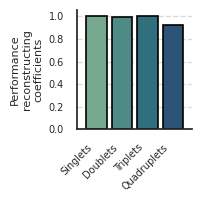

In [423]:
corr_series = multiplet_results['norm-trim_offset_norm_p']['comparison'].loc['overall_coefs_corr']

downsampled_singlet_mapper = downsampled_singlet_results['comparison'].iloc[:, 1:].loc['overall_coefs_corr']
downsampled_singlet_mapper.index = downsampled_singlet_mapper.index.map(downsampled_singlet_size_mapper)

# Create the interpolator
interpolator = interp1d(downsampled_singlet_mapper.values, downsampled_singlet_mapper.index, 
                        bounds_error=False, fill_value='extrapolate')

singlet_value = 1
doublet_value = interpolator(corr_series.loc['equal_cells_doublets'])/cell_subset_size_mapper['equal_cells_doublets']
triplet_value = interpolator(corr_series.loc['equal_cells_triplets'])/cell_subset_size_mapper['equal_cells_triplets']
quadruplet_value = interpolator(corr_series.loc['equal_cells_quadruplets'])/cell_subset_size_mapper['equal_cells_quadruplets']

series = {1: singlet_value, 2:doublet_value, 3:triplet_value, 4:quadruplet_value}

# Create a list of the keys and values from the series dictionary
categories = list(series.keys())
values = list(series.values())

# Create the barplot
fig, ax = plt.subplots(figsize=(2, 2))
bars = sns.barplot(x=categories, y=values, palette='crest', edgecolor='black', linewidth=1.2, ax=ax)

# Set the x-tick positions and labels
ax.set_xticks([i - 0.1 for i in range(len(categories))])  # Shift the x-ticks to the left
ax.set_xticklabels(['Singlets', 'Doublets', 'Triplets', 'Quadruplets'], fontsize=7, rotation=45, ha='right')

# Customize the appearance
ax.set_ylabel('Performance\nreconstructing\ncoefficients', fontsize=8)
ax.tick_params(axis='y', labelsize=7)
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlim([-0.75, 3.75])

# Adjust the layout and display the plot
plt.tight_layout()
plt.savefig('20240408_performance_ratio.pdf', bbox_inches='tight')

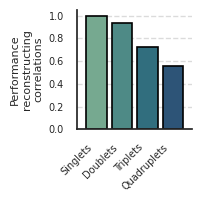

In [424]:
corr_series = multiplet_results['norm-trim_offset_norm_p']['comparison'].loc['overall_pairwise_corr']

downsampled_singlet_mapper = downsampled_singlet_results['comparison'].iloc[:, 1:].loc['overall_pairwise_corr']
downsampled_singlet_mapper.index = downsampled_singlet_mapper.index.map(downsampled_singlet_size_mapper)

# Create the interpolator
interpolator = interp1d(downsampled_singlet_mapper.values, downsampled_singlet_mapper.index, 
                        bounds_error=False, fill_value='extrapolate')

singlet_value = 1
doublet_value = interpolator(corr_series.loc['equal_cells_doublets'])/cell_subset_size_mapper['equal_cells_doublets']
triplet_value = interpolator(corr_series.loc['equal_cells_triplets'])/cell_subset_size_mapper['equal_cells_triplets']
quadruplet_value = interpolator(corr_series.loc['equal_cells_quadruplets'])/cell_subset_size_mapper['equal_cells_quadruplets']

series = {1: singlet_value, 2:doublet_value, 3:triplet_value, 4:quadruplet_value}

# Create a list of the keys and values from the series dictionary
categories = list(series.keys())
values = list(series.values())

# Create the barplot
fig, ax = plt.subplots(figsize=(2, 2))
bars = sns.barplot(x=categories, y=values, palette='crest', edgecolor='black', linewidth=1.2, ax=ax)

# Customize the appearance
ax.set_ylabel('Performance\nreconstructing\ncorrelations', fontsize=8)

# Set the x-tick positions and labels
ax.set_xticks([i - 0.1 for i in range(len(categories))])  # Shift the x-ticks to the left
ax.set_xticklabels(['Singlets', 'Doublets', 'Triplets', 'Quadruplets'], fontsize=7, rotation=45, ha='right')

ax.tick_params(axis='y', labelsize=7)
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlim([-0.75, 3.75])

# Adjust the layout and display the plot
plt.tight_layout()
plt.savefig('20240408_performance_ratio_pairwise_corrs.pdf', bbox_inches='tight')

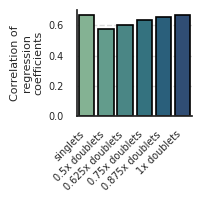

In [408]:
corr_series = multiplet_results['norm-trim_offset_norm_p']['comparison'].loc['overall_coefs_corr']
corr_series = corr_series[corr_series.index.str.contains('doublets')|corr_series.index.str.contains('baseline')]
#corr_series.index = corr_series.index.map(cell_subset_size_mapper)
corr_series.index = ['singlets', '1x doublets', '1.25x doublets', '1.5x doublets', '1.75x doublets', '2x doublets']

categories = list(corr_series.index)
values = list(corr_series.values)

fig, ax = plt.subplots(figsize=(2, 2))
bars = sns.barplot(x=categories, y=values, palette='crest', edgecolor='black', linewidth=1.2, ax=ax)

# Customize the appearance
ax.set_ylabel('Correlation of\nregression\ncoefficients', fontsize=8)
#ax.set_xticks(categories)
ax.set_xticklabels(['singlets', '0.5x doublets', '0.625x doublets', '0.75x doublets', '0.875x doublets', '1x doublets'], fontsize=7, rotation=45, ha='right')
ax.tick_params(axis='y', labelsize=7)
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Adjust the layout and display the plot
plt.tight_layout()
plt.savefig('20240408_doublet_downsampling_performance_ratio.pdf', bbox_inches='tight')

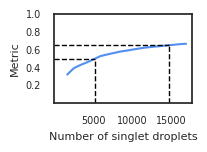

In [395]:
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt

downsampled_singlet_mapper = downsampled_singlet_results['comparison'].iloc[:, 1:].loc['overall_coefs_corr']
downsampled_singlet_mapper.index = downsampled_singlet_mapper.index.map(downsampled_singlet_size_mapper)

# Create the interpolator
interpolator = interp1d(downsampled_singlet_mapper.values, downsampled_singlet_mapper.index,
                        bounds_error=False, fill_value='extrapolate')

plt.figure(figsize=(2, 1.5))
plt.plot(downsampled_singlet_mapper.index, downsampled_singlet_mapper, color='#528FF0')

# Set the x-limit and y-limit of the plot
plt.xlim(left=0)
plt.ylim([0, 1])
plt.xticks(np.arange(5000, 20000, 5000))
plt.yticks(np.arange(0.2, 1.2, 0.2))
plt.tick_params(axis='both', labelsize=7)
plt.xlabel('Number of singlet droplets', fontsize=8)
plt.ylabel('Metric', fontsize=8)

# Draw the horizontal dashed line at y=0.5
y_value = 0.5
x_min, x_max = plt.xlim()

# Find the corresponding x-value using the interpolator
x_value = interpolator(y_value)

# Calculate the relative position of the intersection point on the x-axis
x_rel = (x_value - x_min) / (x_max - x_min)

# Draw the horizontal dashed line from the y-axis to the intersection point
plt.axhline(y=y_value, color='black', linestyle='--', linewidth=1, xmax=x_rel)

# Draw the vertical dashed line from the intersection point to the x-axis
plt.axvline(x=x_value, color='black', linestyle='--', linewidth=1, ymax=(y_value - plt.ylim()[0]) / (plt.ylim()[1] - plt.ylim()[0]))


# Draw the horizontal dashed line at y=0.5
y_value = 0.65
x_min, x_max = plt.xlim()

# Find the corresponding x-value using the interpolator
x_value = interpolator(y_value)

# Calculate the relative position of the intersection point on the x-axis
x_rel = (x_value - x_min) / (x_max - x_min)

# Draw the horizontal dashed line from the y-axis to the intersection point
plt.axhline(y=y_value, color='black', linestyle='--', linewidth=1, xmax=x_rel)

# Draw the vertical dashed line from the intersection point to the x-axis
plt.axvline(x=x_value, color='black', linestyle='--', linewidth=1, ymax=(y_value - plt.ylim()[0]) / (plt.ylim()[1] - plt.ylim()[0]))


plt.tight_layout()
plt.savefig('20240408_downsampled_singlet_calibration_curve.pdf', bbox_inches='tight')

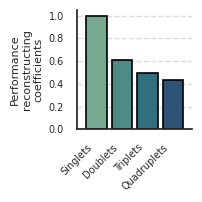

In [425]:
corr_series = multiplet_results['norm-gemgroup']['comparison'].loc['overall_coefs_corr']

downsampled_singlet_mapper = downsampled_singlet_results['comparison'].iloc[:, 1:].loc['overall_coefs_corr']
downsampled_singlet_mapper.index = downsampled_singlet_mapper.index.map(downsampled_singlet_size_mapper)

# Create the interpolator
interpolator = interp1d(downsampled_singlet_mapper.values, downsampled_singlet_mapper.index, 
                        bounds_error=False, fill_value='extrapolate')

singlet_value = 1
doublet_value = interpolator(corr_series.loc['equal_cells_doublets'])/cell_subset_size_mapper['equal_cells_doublets']
triplet_value = interpolator(corr_series.loc['equal_cells_triplets'])/cell_subset_size_mapper['equal_cells_triplets']
quadruplet_value = interpolator(corr_series.loc['equal_cells_quadruplets'])/cell_subset_size_mapper['equal_cells_quadruplets']

series = {1: singlet_value, 2:doublet_value, 3:triplet_value, 4:quadruplet_value}

# Create a list of the keys and values from the series dictionary
categories = list(series.keys())
values = list(series.values())

# Create the barplot
fig, ax = plt.subplots(figsize=(2, 2))
bars = sns.barplot(x=categories, y=values, palette='crest', edgecolor='black', linewidth=1.2, ax=ax)

# Set the x-tick positions and labels
ax.set_xticks([i - 0.1 for i in range(len(categories))])  # Shift the x-ticks to the left
ax.set_xticklabels(['Singlets', 'Doublets', 'Triplets', 'Quadruplets'], fontsize=7, rotation=45, ha='right')

# Customize the appearance
ax.set_ylabel('Performance\nreconstructing\ncoefficients', fontsize=8)
ax.tick_params(axis='y', labelsize=7)
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlim([-0.75, 3.75])

# Adjust the layout and display the plot
plt.tight_layout()
plt.savefig('20240408_GEMGROUP_performance_ratio.pdf', bbox_inches='tight')

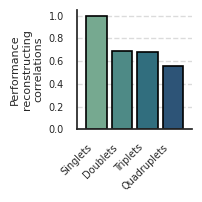

In [426]:
corr_series = multiplet_results['norm-gemgroup']['comparison'].loc['overall_pairwise_corr']

downsampled_singlet_mapper = downsampled_singlet_results['comparison'].iloc[:, 1:].loc['overall_pairwise_corr']
downsampled_singlet_mapper.index = downsampled_singlet_mapper.index.map(downsampled_singlet_size_mapper)

# Create the interpolator
interpolator = interp1d(downsampled_singlet_mapper.values, downsampled_singlet_mapper.index, 
                        bounds_error=False, fill_value='extrapolate')

singlet_value = 1
doublet_value = interpolator(corr_series.loc['equal_cells_doublets'])/cell_subset_size_mapper['equal_cells_doublets']
triplet_value = interpolator(corr_series.loc['equal_cells_triplets'])/cell_subset_size_mapper['equal_cells_triplets']
quadruplet_value = interpolator(corr_series.loc['equal_cells_quadruplets'])/cell_subset_size_mapper['equal_cells_quadruplets']

series = {1: singlet_value, 2:doublet_value, 3:triplet_value, 4:quadruplet_value}

# Create a list of the keys and values from the series dictionary
categories = list(series.keys())
values = list(series.values())

# Create the barplot
fig, ax = plt.subplots(figsize=(2, 2))
bars = sns.barplot(x=categories, y=values, palette='crest', edgecolor='black', linewidth=1.2, ax=ax)

# Customize the appearance
ax.set_ylabel('Performance\nreconstructing\ncorrelations', fontsize=8)

# Set the x-tick positions and labels
ax.set_xticks([i - 0.1 for i in range(len(categories))])  # Shift the x-ticks to the left
ax.set_xticklabels(['Singlets', 'Doublets', 'Triplets', 'Quadruplets'], fontsize=7, rotation=45, ha='right')

ax.tick_params(axis='y', labelsize=7)
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlim([-0.75, 3.75])

# Adjust the layout and display the plot
plt.tight_layout()
plt.savefig('20240408_GEMGROUP_performance_ratio_pairwise_corrs.pdf', bbox_inches='tight')

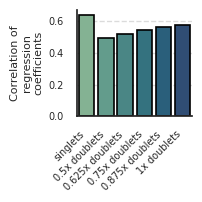

In [427]:
corr_series = multiplet_results['norm-gemgroup']['comparison'].loc['overall_coefs_corr']
corr_series = corr_series[corr_series.index.str.contains('doublets')|corr_series.index.str.contains('baseline')]
#corr_series.index = corr_series.index.map(cell_subset_size_mapper)
corr_series.index = ['singlets', '1x doublets', '1.25x doublets', '1.5x doublets', '1.75x doublets', '2x doublets']

categories = list(corr_series.index)
values = list(corr_series.values)

fig, ax = plt.subplots(figsize=(2, 2))
bars = sns.barplot(x=categories, y=values, palette='crest', edgecolor='black', linewidth=1.2, ax=ax)

# Customize the appearance
ax.set_ylabel('Correlation of\nregression\ncoefficients', fontsize=8)
#ax.set_xticks(categories)
ax.set_xticklabels(['singlets', '0.5x doublets', '0.625x doublets', '0.75x doublets', '0.875x doublets', '1x doublets'], fontsize=7, rotation=45, ha='right')
ax.tick_params(axis='y', labelsize=7)
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Adjust the layout and display the plot
plt.tight_layout()
plt.savefig('20240408_GEMGROUP_doublet_downsampling_performance_ratio.pdf', bbox_inches='tight')

In [448]:
Z_row = linkage(full_results['norm-trim_offset_norm_p']['norm_coef']['singlets'],
               method='average', metric='correlation', optimal_ordering=True)

Z_col = linkage(full_results['norm-trim_offset_norm_p']['norm_coef']['singlets'].T,
               method='average', metric='correlation', optimal_ordering=True)

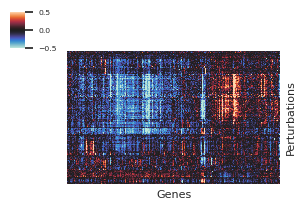

In [362]:
cmap = sns.clustermap(full_results['norm-trim_offset_norm_p']['norm_coef']['singlets'],
                      row_linkage=Z_row, col_linkage=Z_col, robust=True, center=0,
                      xticklabels=[], yticklabels=[], figsize=[3, 2], vmin=-0.5, vmax=0.5)

plt.setp(cmap.ax_heatmap.get_xticklabels(), visible=False)
plt.setp(cmap.ax_heatmap.get_yticklabels(), visible=False)
cmap.ax_row_dendrogram.set_visible(False)
cmap.ax_col_dendrogram.set_visible(False)

cmap.ax_heatmap.set_xlabel('Genes', fontsize=8)

# Set the y-axis label
cmap.ax_heatmap.set_ylabel('Perturbations', fontsize=8)

cmap.savefig('20240408_singlet_expression_heatmap_LEGEND.pdf', bbox_inches='tight')

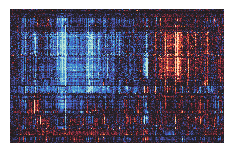

In [363]:
cmap = sns.clustermap(full_results['norm-trim_offset_norm_p']['norm_coef']['singlets'],
                      row_linkage=Z_row, col_linkage=Z_col, robust=True, center=0,
                      xticklabels=[], yticklabels=[], figsize=[3, 2], vmin=-0.5, vmax=0.5,
                      )  # Set cbar=False to remove the colorbar

plt.setp(cmap.ax_heatmap.get_xticklabels(), visible=False)
plt.setp(cmap.ax_heatmap.get_yticklabels(), visible=False)

cmap.cax.set_visible(False)

cmap.ax_row_dendrogram.set_visible(False)
cmap.ax_col_dendrogram.set_visible(False)

# Remove the x-axis and y-axis labels
cmap.ax_heatmap.set_xlabel('')
cmap.ax_heatmap.set_ylabel('')
cmap.savefig('20240408_singlet_expression_heatmap.png', bbox_inches='tight')

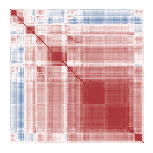

In [368]:
C = full_results['norm-trim_offset_norm_p']['norm_coef']['singlets'].T.corr()

Z = linkage(C, method='average', metric='correlation', optimal_ordering=True)

cmap = sns.clustermap(C,
                      row_linkage=Z, col_linkage=Z, robust=True, center=0,
                      xticklabels=[], yticklabels=[], figsize=[2, 2], vmin=-0.8, vmax=0.8, cmap='vlag')

plt.setp(cmap.ax_heatmap.get_xticklabels(), visible=False)
plt.setp(cmap.ax_heatmap.get_yticklabels(), visible=False)
cmap.ax_row_dendrogram.set_visible(False)
cmap.ax_col_dendrogram.set_visible(False)

cmap.cax.set_visible(False)

cmap.ax_heatmap.set_xlabel('')
cmap.ax_heatmap.set_ylabel('')
cmap.savefig('20240408_singlet_correlation_heatmap.png', bbox_inches='tight')

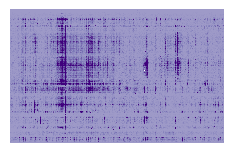

In [478]:
P = -np.log10(full_results['norm-trim_offset_norm_p']['adj_p']['singlets']).loc[full_results['norm-trim_offset_norm_p']['norm_coef']['singlets'].index]

# Z_row = linkage(P, method='average', metric='correlation', optimal_ordering=True)
# Z_col = linkage(P.T, method='average', metric='correlation', optimal_ordering=True)

cmap = sns.clustermap(P,
                      row_linkage=Z_row, col_linkage=Z_col, robust=True, center=0,
                      xticklabels=[], yticklabels=[], figsize=[3, 2], cmap='Purples', vmin=0, vmax=10)

plt.setp(cmap.ax_heatmap.get_xticklabels(), visible=False)
plt.setp(cmap.ax_heatmap.get_yticklabels(), visible=False)
cmap.ax_row_dendrogram.set_visible(False)
cmap.ax_col_dendrogram.set_visible(False)

cmap.cax.set_visible(False)

cmap.ax_heatmap.set_xlabel('')
cmap.ax_heatmap.set_ylabel('')
cmap.savefig('20240408_singlet_pvalue_heatmap.png', bbox_inches='tight')

Text(185.55555555555551, 0.5, 'Perturbations')

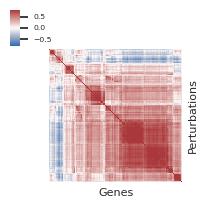

In [367]:
C = full_results['norm-trim_offset_norm_p']['norm_coef']['singlets'].T.corr()

Z = linkage(C, method='average', metric='correlation', optimal_ordering=True)

cmap = sns.clustermap(C,
                      row_linkage=Z, col_linkage=Z, robust=True, center=0,
                      xticklabels=[], yticklabels=[], figsize=[2, 2], vmin=-0.8, vmax=0.8, cmap='vlag')

plt.setp(cmap.ax_heatmap.get_xticklabels(), visible=False)
plt.setp(cmap.ax_heatmap.get_yticklabels(), visible=False)
cmap.ax_row_dendrogram.set_visible(False)
cmap.ax_col_dendrogram.set_visible(False)

cmap.ax_heatmap.set_xlabel('Genes', fontsize=8)

# Set the y-axis label
cmap.ax_heatmap.set_ylabel('Perturbations', fontsize=8)

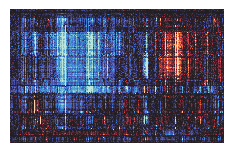

In [347]:
cmap = sns.clustermap(full_results['norm-trim_offset_norm_p']['norm_coef']['full'],
                      row_linkage=Z_row, col_linkage=Z_col, robust=True, center=0,
                      xticklabels=[], yticklabels=[], figsize=[3, 2], vmin=-0.5, vmax=0.5)

plt.setp(cmap.ax_heatmap.get_xticklabels(), visible=False)
plt.setp(cmap.ax_heatmap.get_yticklabels(), visible=False)
cmap.ax_row_dendrogram.set_visible(False)
cmap.ax_col_dendrogram.set_visible(False)

cmap.cax.set_visible(False)

cmap.ax_heatmap.set_xlabel('')
cmap.ax_heatmap.set_ylabel('')

cmap.savefig('20240408_reconstructed_expression_heatmap.png', bbox_inches='tight')

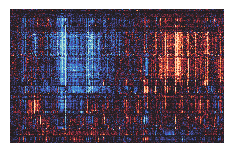

In [348]:
cmap = sns.clustermap(full_results['norm-gemgroup']['norm_coef']['singlets'],
                      row_linkage=Z_row, col_linkage=Z_col, robust=True, center=0,
                      xticklabels=[], yticklabels=[], figsize=[3, 2], vmin=-0.5, vmax=0.5)

plt.setp(cmap.ax_heatmap.get_xticklabels(), visible=False)
plt.setp(cmap.ax_heatmap.get_yticklabels(), visible=False)
cmap.ax_row_dendrogram.set_visible(False)
cmap.ax_col_dendrogram.set_visible(False)

cmap.cax.set_visible(False)

cmap.ax_heatmap.set_xlabel('')
cmap.ax_heatmap.set_ylabel('')

cmap.savefig('20240408_GEMGROUP_singlet_expression_heatmap.png', bbox_inches='tight')

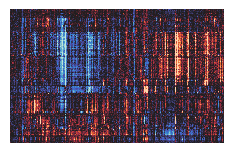

In [349]:
cmap = sns.clustermap(full_results['norm-gemgroup']['norm_coef']['full'],
                      row_linkage=Z_row, col_linkage=Z_col, robust=True, center=0,
                      xticklabels=[], yticklabels=[], figsize=[3, 2], vmin=-0.5, vmax=0.5)

plt.setp(cmap.ax_heatmap.get_xticklabels(), visible=False)
plt.setp(cmap.ax_heatmap.get_yticklabels(), visible=False)
cmap.ax_row_dendrogram.set_visible(False)
cmap.ax_col_dendrogram.set_visible(False)

cmap.cax.set_visible(False)

cmap.ax_heatmap.set_xlabel('')
cmap.ax_heatmap.set_ylabel('')

cmap.savefig('20240408_GEMGROUP_reconstructed_expression_heatmap.png', bbox_inches='tight')

# P-value comparisons

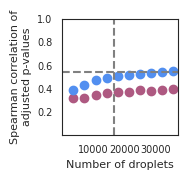

In [30]:
baseline_result = single_results['norm-trim_offset_norm_p']['adj_p_comparison'].loc['overall_coefs_corr', 'baseline']
baseline_number = len(remaining_singlets)

plt.figure(figsize=(1.5, 1.5))

results = single_results['norm-gemgroup']['adj_p_comparison'].iloc[:, 1:].loc['overall_coefs_corr']
results.index = results.index.map(droplet_size_mapper)

plt.scatter(results.index, results, color='#AE5981')

results = single_results['norm-trim_offset_norm_p']['adj_p_comparison'].iloc[:, 1:].loc['overall_coefs_corr']
results.index = results.index.map(droplet_size_mapper)

plt.scatter(results.index, results, color='#528FF0')

# Plot the dashed horizontal line at baseline_result
plt.axhline(y=baseline_result, color='gray', linestyle='--', linewidth=1.5)

# Plot the dashed vertical line at baseline_number
plt.axvline(x=baseline_number, color='gray', linestyle='--', linewidth=1.5)

# Set the x-limit and y-limit of the plot
plt.xlim(left=0)
plt.ylim([0,1])

plt.xticks(np.arange(10000, 40000, 10000))
plt.yticks(np.arange(0.2, 1.2, 0.2))

plt.tick_params(axis='both', labelsize=7)

plt.xlabel('Number of droplets', fontsize=8)
plt.ylabel('Spearman correlation of\nadjusted p-values', fontsize=8)

plt.savefig('20240408_PVAL_correlation_of_coefficients_vs_gemgroup.pdf', bbox_inches='tight')

In [38]:
# original comparison code directly summed the adj_p matrix to make counts because I forgot I had switched away from a binary matrix

In [39]:
adj_ps = single_results['norm-gemgroup']['adj_p']

In [42]:
def mod_compare_coefs(coefs, baseline_coefs, method='pearson', print_results=True, only_perturbations=True, name=None, p_compare=False):
    
    if only_perturbations:
        target_coefs = coefs.loc[non_control_perturbations].copy()
        compare_coefs = baseline_coefs.loc[non_control_perturbations].copy()
    else:
        target_coefs = coefs
        compare_coefs = baseline_coefs
    
    profile_corrs = target_coefs.corrwith(compare_coefs, method=method)
    gene_corrs = target_coefs.corrwith(compare_coefs, method=method, axis=1)
    
    pert_C = target_coefs.corr()
    baseline_C = compare_coefs.corr()
    
    corr_corrs = pert_C.corrwith(baseline_C, method=method)    
    
    overall_pairwise_corr = pert_C.stack().corr(baseline_C.stack(), method=method)
    overall_coefs_corr = target_coefs.stack().corr(compare_coefs.stack(), method=method)
    
    summary_stats = {
        'mean_profile_corr': profile_corrs.mean(),
        'median_profile_corr': profile_corrs.median(),
        'mean_gene_corr': gene_corrs.mean(),
        'median_gene_corr': gene_corrs.median(),
        'mean_corr_corr': corr_corrs.mean(),
        'median_corr_corr': corr_corrs.median(),
        'overall_pairwise_corr': overall_pairwise_corr,
        'overall_coefs_corr': overall_coefs_corr
    }
    
    if p_compare:
        counts = (target_coefs < 0.05).sum(axis=1)
        baseline_counts = (compare_coefs < 0.05).sum(axis=1)
        strong_perts = baseline_counts[baseline_counts > 30].index
        
        summary_stats['count_corr'] = counts.corr(baseline_counts, method='spearman')
        summary_stats['strong_count_corr'] = counts.loc[strong_perts].corr(baseline_counts.loc[strong_perts], method='spearman')
        
    if print_results:
        for key, value in summary_stats.items():
            print(f'{key.upper()}: {value:.3f}')

    return pd.Series(summary_stats, name=name)

In [ ]:
adj_p_comparisons = dict()

In [52]:
for rate, cells in subsampled_cells.items():
    adj_p_comparisons[rate] = compare_coefs(adj_ps['ground'], adj_ps[rate], p_compare=True, method='spearman')

MEAN_PROFILE_CORR: 0.301
MEDIAN_PROFILE_CORR: 0.288
MEAN_GENE_CORR: 0.119
MEDIAN_GENE_CORR: 0.095
MEAN_CORR_CORR: 0.228
MEDIAN_CORR_CORR: 0.219
OVERALL_PAIRWISE_CORR: 0.282
OVERALL_COEFS_CORR: 0.317
COUNT_CORR: 0.645
STRONG_COUNT_CORR: 0.645
MEAN_PROFILE_CORR: 0.285
MEDIAN_PROFILE_CORR: 0.269
MEAN_GENE_CORR: 0.168
MEDIAN_GENE_CORR: 0.129
MEAN_CORR_CORR: 0.294
MEDIAN_CORR_CORR: 0.277
OVERALL_PAIRWISE_CORR: 0.354
OVERALL_COEFS_CORR: 0.314
COUNT_CORR: 0.699
STRONG_COUNT_CORR: 0.699
MEAN_PROFILE_CORR: 0.304
MEDIAN_PROFILE_CORR: 0.281
MEAN_GENE_CORR: 0.200
MEDIAN_GENE_CORR: 0.184
MEAN_CORR_CORR: 0.315
MEDIAN_CORR_CORR: 0.298
OVERALL_PAIRWISE_CORR: 0.375
OVERALL_COEFS_CORR: 0.342
COUNT_CORR: 0.696
STRONG_COUNT_CORR: 0.696
MEAN_PROFILE_CORR: 0.315
MEDIAN_PROFILE_CORR: 0.291
MEAN_GENE_CORR: 0.223
MEDIAN_GENE_CORR: 0.199
MEAN_CORR_CORR: 0.318
MEDIAN_CORR_CORR: 0.302
OVERALL_PAIRWISE_CORR: 0.373
OVERALL_COEFS_CORR: 0.358
COUNT_CORR: 0.704
STRONG_COUNT_CORR: 0.704
MEAN_PROFILE_CORR: 0.324
MEDIAN_

In [56]:
adj_ps = single_results['norm-gemgroup']['adj_p']

In [53]:
mod_adj_p_comparisons = dict()

In [ ]:
for rate, cells in subsampled_cells.items():
    mod_adj_p_comparisons[rate] = mod_compare_coefs(adj_ps['ground'], adj_ps[rate], p_compare=True, method='spearman')

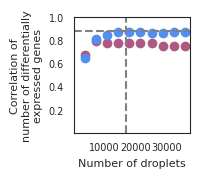

In [72]:
baseline_number = len(remaining_singlets)

plt.figure(figsize=(1.5, 1.5))

results = pd.Series({num: d['count_corr'] for num, d in mod_adj_p_comparisons.items()})
results.index = results.index.map(droplet_size_mapper)

plt.scatter(results.index, results, color='#AE5981')

results = pd.Series({num: d['count_corr'] for num, d in norm_trim_mod_adj_p_comparisons.items()})
results.index = results.index.map(droplet_size_mapper)

plt.scatter(results.index, results, color='#528FF0')

# Plot the dashed horizontal line at baseline_result
plt.axhline(y=baseline_result, color='gray', linestyle='--', linewidth=1.5)

# Plot the dashed vertical line at baseline_number
plt.axvline(x=baseline_number, color='gray', linestyle='--', linewidth=1.5)

# Set the x-limit and y-limit of the plot
plt.xlim(left=0)
plt.ylim([0,1])

plt.xticks(np.arange(10000, 40000, 10000))
plt.yticks(np.arange(0.2, 1.2, 0.2))

plt.tick_params(axis='both', labelsize=7)

plt.xlabel('Number of droplets', fontsize=8)
plt.ylabel('Correlation of\nnumber of differentially\nexpressed genes', fontsize=8)

plt.savefig('20240419_PVAL_count_correlation_vs_gemgroup_FIXED.pdf', bbox_inches='tight')

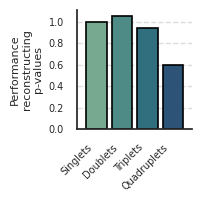

In [428]:
corr_series = multiplet_results['norm-trim_offset_norm_p']['adj_p_comparison'].loc['overall_coefs_corr']

downsampled_singlet_mapper = downsampled_singlet_results['adj_p_comparison'].iloc[:, 1:].loc['overall_coefs_corr']
downsampled_singlet_mapper.index = downsampled_singlet_mapper.index.map(downsampled_singlet_size_mapper)

# Create the interpolator
interpolator = interp1d(downsampled_singlet_mapper.values, downsampled_singlet_mapper.index, 
                        bounds_error=False, fill_value='extrapolate')

singlet_value = 1
doublet_value = interpolator(corr_series.loc['equal_cells_doublets'])/cell_subset_size_mapper['equal_cells_doublets']
triplet_value = interpolator(corr_series.loc['equal_cells_triplets'])/cell_subset_size_mapper['equal_cells_triplets']
quadruplet_value = interpolator(corr_series.loc['equal_cells_quadruplets'])/cell_subset_size_mapper['equal_cells_quadruplets']

series = {1: singlet_value, 2:doublet_value, 3:triplet_value, 4:quadruplet_value}

# Create a list of the keys and values from the series dictionary
categories = list(series.keys())
values = list(series.values())

# Create the barplot
fig, ax = plt.subplots(figsize=(2, 2))
bars = sns.barplot(x=categories, y=values, palette='crest', edgecolor='black', linewidth=1.2, ax=ax)

# Set the x-tick positions and labels
ax.set_xticks([i - 0.1 for i in range(len(categories))])  # Shift the x-ticks to the left
ax.set_xticklabels(['Singlets', 'Doublets', 'Triplets', 'Quadruplets'], fontsize=7, rotation=45, ha='right')

# Customize the appearance
ax.set_ylabel('Performance\nreconstructing\np-values', fontsize=8)
ax.tick_params(axis='y', labelsize=7)
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlim([-0.75, 3.75])

# Adjust the layout and display the plot
plt.tight_layout()
plt.savefig('20240408_PVAL_performance_ratio.pdf', bbox_inches='tight')

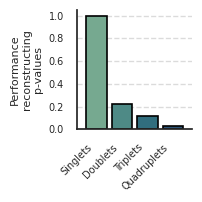

In [429]:
corr_series = multiplet_results['norm-gemgroup']['adj_p_comparison'].loc['overall_coefs_corr']

downsampled_singlet_mapper = downsampled_singlet_results['adj_p_comparison'].iloc[:, 1:].loc['overall_coefs_corr']
downsampled_singlet_mapper.index = downsampled_singlet_mapper.index.map(downsampled_singlet_size_mapper)

# Create the interpolator
interpolator = interp1d(downsampled_singlet_mapper.values, downsampled_singlet_mapper.index, 
                        bounds_error=False, fill_value='extrapolate')

singlet_value = 1
doublet_value = interpolator(corr_series.loc['equal_cells_doublets'])/cell_subset_size_mapper['equal_cells_doublets']
triplet_value = interpolator(corr_series.loc['equal_cells_triplets'])/cell_subset_size_mapper['equal_cells_triplets']
quadruplet_value = interpolator(corr_series.loc['equal_cells_quadruplets'])/cell_subset_size_mapper['equal_cells_quadruplets']

series = {1: singlet_value, 2:doublet_value, 3:triplet_value, 4:quadruplet_value}

# Create a list of the keys and values from the series dictionary
categories = list(series.keys())
values = list(series.values())

# Create the barplot
fig, ax = plt.subplots(figsize=(2, 2))
bars = sns.barplot(x=categories, y=values, palette='crest', edgecolor='black', linewidth=1.2, ax=ax)

# Set the x-tick positions and labels
ax.set_xticks([i - 0.1 for i in range(len(categories))])  # Shift the x-ticks to the left
ax.set_xticklabels(['Singlets', 'Doublets', 'Triplets', 'Quadruplets'], fontsize=7, rotation=45, ha='right')

# Customize the appearance
ax.set_ylabel('Performance\nreconstructing\np-values', fontsize=8)
ax.tick_params(axis='y', labelsize=7)
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlim([-0.75, 3.75])

# Adjust the layout and display the plot
plt.tight_layout()
plt.savefig('20240408_PVAL_GEMGROUP_performance_ratio.pdf', bbox_inches='tight')

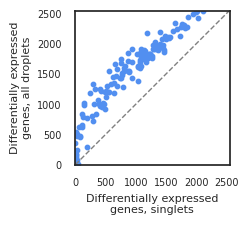

In [479]:
import matplotlib.pyplot as plt
import numpy as np

full_counts = (full_results['norm-trim_offset_norm_p']['adj_p']['full'] < 0.05).sum(axis=1)
full_counts = full_counts[full_counts.index != 'control']

singlet_counts = (full_results['norm-trim_offset_norm_p']['adj_p']['singlets'] < 0.05).sum(axis=1)
singlet_counts = singlet_counts[singlet_counts.index != 'control']

plt.figure(figsize=(2, 2))
plt.scatter(singlet_counts, full_counts, color='#528FF0', s=10)

# Find the maximum value for the x and y limits
max_value = max(singlet_counts.max(), full_counts.max())

# Plot the diagonal dashed line
plt.plot([0, max_value], [0, max_value], '--', color='gray', linewidth=1)

plt.xlabel('Differentially expressed\ngenes, singlets', fontsize=8)
plt.ylabel('Differentially expressed\ngenes, all droplets', fontsize=8)

# Set equal scaling for both axes
plt.axis('equal')

# Set the x and y limits to start from 0 and go up to the maximum value
plt.xlim(0, max_value)
plt.ylim(0, max_value)

# Set the x-ticks and y-ticks
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)

#plt.tight_layout()
plt.savefig('20240408_additional_differentially_expressed_genes.pdf', bbox_inches='tight')